In [1]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost
import plotnine as pn
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import DBSCAN, MeanShift, KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [5]:
with zipfile.ZipFile('/content/online+retail+ii.zip', 'r') as zipref:
  zipref.extractall('/content/')

In [6]:
df = pd.read_excel('/content/online_retail_II.xlsx')

In [ ]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [ ]:
df.tail()

Invoice StockCode                         Description  Quantity  \
525456  538171     22271                FELTCRAFT DOLL ROSIE         2   
525457  538171     22750        FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751      FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970  PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931              JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID         Country  
525456 2010-12-09 20:01:00   2.95      17530.0  United Kingdom  
525457 2010-12-09 20:01:00   3.75      17530.0  United Kingdom  
525458 2010-12-09 20:01:00   3.75      17530.0  United Kingdom  
525459 2010-12-09 20:01:00   3.75      17530.0  United Kingdom  
525460 2010-12-09 20:01:00   1.95      17530.0  United Kingdom

In [ ]:
df.describe()

Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   
25%         1.000000            2010-03-21 12:20:00       1.250000   
50%         3.000000            2010-07-06 09:51:00       2.100000   
75%        10.000000            2010-10-15 12:45:00       4.210000   
max     19152.000000            2010-12-09 20:01:00   25111.090000   
std       107.424110                            NaN     146.126914   

         Customer ID  
count  417534.000000  
mean    15360.645478  
min     12346.000000  
25%     13983.000000  
50%     15311.000000  
75%     16799.000000  
max     18287.000000  
std      1680.811316

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [ ]:
df.duplicated().sum()

6865

In [7]:
df = df.drop_duplicates()

In [ ]:
df.shape

(518596, 8)

In [8]:
sorted_df = df.sort_values(['Customer ID', 'InvoiceDate'])
sorted_df

Invoice StockCode              Description  Quantity  \
27994   491725   TEST001  This is a test product.        10   
28251   491742   TEST001  This is a test product.         5   
28254   491744   TEST001  This is a test product.         5   
39398   492718   TEST001  This is a test product.         5   
39411   492722   TEST002  This is a test product.         1   
...        ...       ...                      ...       ...   
525231  538159     21324                      NaN       -18   
525232  538158     20892                      NaN       -32   
525233  538160     20956                      NaN       288   
525234  538161    46000S             Dotcom sales      -100   
525235  538162    46000M             Dotcom sales      -100   

               InvoiceDate  Price  Customer ID         Country  
27994  2009-12-14 08:34:00    4.5      12346.0  United Kingdom  
28251  2009-12-14 11:00:00    4.5      12346.0  United Kingdom  
28254  2009-12-14 11:02:00    4.5      12346.0  United Kingdom  
39398  2009-12-18 10:47:00    4.5      12346.0  United Kingdom  
39411  2009-12-18 10:55:00    1.0      12346.0  United Kingdom  
...                    ...    ...          ...             ...  
525231 2010-12-09 17:17:00    0.0          NaN  United Kingdom  
525232 2010-12-09 17:17:00    0.0          NaN  United Kingdom  
525233 2010-12-09 17:18:00    0.0          NaN  United Kingdom  
525234 2010-12-09 17:25:00    0.0          NaN  United Kingdom  
525235 2010-12-09 17:25:00    0.0          NaN  United Kingdom  

[518596 rows x 8 columns]

In [ ]:
sorted_df.head(14)

Invoice StockCode                          Description  Quantity  \
27994    491725   TEST001              This is a test product.        10   
28251    491742   TEST001              This is a test product.         5   
28254    491744   TEST001              This is a test product.         5   
39398    492718   TEST001              This is a test product.         5   
39411    492722   TEST002              This is a test product.         1   
45228    493410   TEST001              This is a test product.         5   
45230    493412   TEST001              This is a test product.         5   
56117    494450   TEST001              This is a test product.         5   
66084    495295   TEST001              This is a test product.         5   
71080   C495800    ADJUST  Adjustment by john on 26/01/2010 17        -1   
107800   499763     20682           RED SPOTTY CHILDS UMBRELLA         1   
107801   499763     20679                EDWARDIAN PARASOL RED         1   
107802   499763    15056N            EDWARDIAN PARASOL NATURAL         1   
107803   499763   15056BL              EDWARDIAN PARASOL BLACK         1   

               InvoiceDate   Price  Customer ID         Country  
27994  2009-12-14 08:34:00    4.50      12346.0  United Kingdom  
28251  2009-12-14 11:00:00    4.50      12346.0  United Kingdom  
28254  2009-12-14 11:02:00    4.50      12346.0  United Kingdom  
39398  2009-12-18 10:47:00    4.50      12346.0  United Kingdom  
39411  2009-12-18 10:55:00    1.00      12346.0  United Kingdom  
45228  2010-01-04 09:24:00    4.50      12346.0  United Kingdom  
45230  2010-01-04 09:53:00    4.50      12346.0  United Kingdom  
56117  2010-01-14 13:50:00    4.50      12346.0  United Kingdom  
66084  2010-01-22 13:30:00    4.50      12346.0  United Kingdom  
71080  2010-01-26 17:27:00  103.50      12346.0  United Kingdom  
107800 2010-03-02 13:08:00    3.25      12346.0  United Kingdom  
107801 2010-03-02 13:08:00    5.95      12346.0  United Kingdom  
107802 2010-03-02 13:08:00    5.95      12346.0  United Kingdom  
107803 2010-03-02 13:08:00    5.95      12346.0  United Kingdom

In [ ]:
sorted_df.isnull().mean()*100

Invoice         0.000000
StockCode       0.000000
Description     0.564601
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    20.793257
Country         0.000000
dtype: float64

In [9]:
sorted_df['Customer ID'].fillna('Anonymous', inplace=True)

<ipython-input-9-7e7a4c515b98>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Anonymous' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


Handling Missing Customer IDs
In the dataset, some entries in the 'Customer ID' column are missing, indicating that these transactions might have been made by customers who did not create an account. To address this, we have replaced all NaN (null) values in the 'Customer ID' column with the string 'Anonymous'.

This approach allows us to maintain the integrity of the dataset by ensuring that every transaction is associated with a value, even if it is not a specific customer ID

In [ ]:
sorted_df[sorted_df['Customer ID'] == 'Anonymous']

Invoice StockCode                Description  Quantity  \
263     489464     21733               85123a mixed       -96   
283     489463     71477                      short      -240   
284     489467    85123A                21733 mixed      -192   
470     489521     21646                        NaN       -50   
577     489525    85226C  BLUE PULL BACK RACING CAR         1   
...        ...       ...                        ...       ...   
525231  538159     21324                        NaN       -18   
525232  538158     20892                        NaN       -32   
525233  538160     20956                        NaN       288   
525234  538161    46000S               Dotcom sales      -100   
525235  538162    46000M               Dotcom sales      -100   

               InvoiceDate  Price Customer ID         Country  
263    2009-12-01 10:52:00   0.00   Anonymous  United Kingdom  
283    2009-12-01 10:52:00   0.00   Anonymous  United Kingdom  
284    2009-12-01 10:53:00   0.00   Anonymous  United Kingdom  
470    2009-12-01 11:44:00   0.00   Anonymous  United Kingdom  
577    2009-12-01 11:49:00   0.55   Anonymous  United Kingdom  
...                    ...    ...         ...             ...  
525231 2010-12-09 17:17:00   0.00   Anonymous  United Kingdom  
525232 2010-12-09 17:17:00   0.00   Anonymous  United Kingdom  
525233 2010-12-09 17:18:00   0.00   Anonymous  United Kingdom  
525234 2010-12-09 17:25:00   0.00   Anonymous  United Kingdom  
525235 2010-12-09 17:25:00   0.00   Anonymous  United Kingdom  

[107833 rows x 8 columns]

In [ ]:
sorted_df.nunique()

Invoice        28816
StockCode       4632
Description     4681
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4384
Country           40
dtype: int64

In [10]:
null_description = sorted_df[sorted_df['Description'].isna()]['StockCode'].unique()
null_description

array([21646, 20683, 21350, ..., 21324, 20892, 20956], dtype=object)

effectively handles null values in the 'description' column by first attempting to replace them with the most relevant descriptions based on invoice data, and then using 'Unknown' for any remaining nulls. This approach ensures that the dataset remains comprehensive and ready for further analysis.



In [14]:
mapping_df = sorted_df.dropna(subset=['Description'])
stockcode_mapping = mapping_df.set_index('StockCode')['Description'].to_dict()
#setting up dictionary

In [12]:
stockcode_mapping

{'TEST001': 'This is a test product.',
 'TEST002': 'This is a test product.',
 'ADJUST': 'Adjustment by john on 26/01/2010 17',
 20682: 'RED RETROSPOT CHILDRENS UMBRELLA',
 20679: 'EDWARDIAN PARASOL RED',
 '15056N': 'EDWARDIAN PARASOL NATURAL',
 '15056BL': 'EDWARDIAN PARASOL BLACK',
 '15056P': 'EDWARDIAN PARASOL PINK',
 21524: 'DOORMAT SPOTTY HOME SWEET HOME',
 22692: 'DOORMAT WELCOME TO OUR HOME',
 22660: 'DOORMAT I LOVE LONDON',
 22687: 'DOORMAT CHRISTMAS VILLAGE',
 '48173C': 'DOORMAT BLACK FLOCK ',
 22691: 'DOORMAT WELCOME SUNRISE',
 48111: 'DOORMAT 3 SMILEY CATS',
 22690: 'DOORMAT HOME SWEET HOME BLUE ',
 21523: 'DOORMAT FANCY FONT HOME SWEET HOME',
 48138: 'DOORMAT UNION FLAG',
 22689: 'DOORMAT MERRY CHRISTMAS RED ',
 22365: 'DOORMAT RESPECTABLE HOUSE',
 48185: 'DOORMAT FAIRY CAKE',
 22688: 'DOORMAT PEACE ON EARTH BLUE',
 48188: 'DOORMAT WELCOME PUPPIES',
 48187: 'DOORMAT NEW ENGLAND',
 22366: 'DOORMAT AIRMAIL ',
 20685: 'DOORMAT RED RETROSPOT',
 21955: 'DOORMAT UNION JACK GUNS AN

In [15]:
def stock_description(data):
  if pd.isna(data['Description']):
    return stockcode_mapping.get(data['StockCode'], np.nan)
  return data['Description'] #filling the matching null values

In [16]:
sorted_df['Description'] = sorted_df.apply(stock_description, axis = 1)
sorted_df['Description'].isnull().sum()

365

In [ ]:
sorted_df.nunique()

Invoice        28816
StockCode       4632
Description     4681
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4384
Country           40
dtype: int64

In [ ]:
print(sorted_df[sorted_df['StockCode']=='84406B'])

       Invoice StockCode                     Description  Quantity  \
39741   492742    84406B  CREAM CUPID HEARTS COAT HANGER         8   
435561  530970    84406B  CREAM CUPID HEARTS COAT HANGER         8   
257218  514221    84406B  CREAM CUPID HEARTS COAT HANGER        12   
192450  507660    84406B  CREAM CUPID HEARTS COAT HANGER         8   
348245  523305    84406B  CREAM CUPID HEARTS COAT HANGER         1   
...        ...       ...                             ...       ...   
483952  534709    84406B  CREAM CUPID HEARTS COAT HANGER         1   
484031  534709    84406B  CREAM CUPID HEARTS COAT HANGER         3   
497823  535952    84406B  CREAM CUPID HEARTS COAT HANGER         1   
500334  536031    84406B  CREAM CUPID HEARTS COAT HANGER         4   
516758  537434    84406B  CREAM CUPID HEARTS COAT HANGER         1   

               InvoiceDate  Price Customer ID         Country  
39741  2009-12-18 12:33:00   3.25     12455.0          Cyprus  
435561 2010-11-05 09:35:00   3.

In [17]:
sorted_df['Description'] = sorted_df['Description'].fillna('Unknown')
sorted_df['Description'].isnull().sum() #still few null values, so replacing them with Unknown

0

In [ ]:
sorted_df.nunique()

Invoice        28816
StockCode       4632
Description     4682
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4384
Country           40
dtype: int64

In [ ]:
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518596 entries, 27994 to 525235
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      518596 non-null  object        
 1   StockCode    518596 non-null  object        
 2   Description  518596 non-null  object        
 3   Quantity     518596 non-null  int64         
 4   InvoiceDate  518596 non-null  datetime64[ns]
 5   Price        518596 non-null  float64       
 6   Customer ID  518596 non-null  object        
 7   Country      518596 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 35.6+ MB


In [ ]:
sorted_df.describe().T

count                           mean                  min  \
Quantity     518596.0                      10.438152              -9600.0   
InvoiceDate    518596  2010-06-28 06:43:01.573016576  2009-12-01 07:45:00   
Price        518596.0                       4.716176            -53594.36   

                             25%                  50%                  75%  \
Quantity                     1.0                  3.0                 10.0   
InvoiceDate  2010-03-21 11:07:00  2010-07-05 15:42:00  2010-10-15 11:40:00   
Price                       1.25                  2.1                 4.21   

                             max         std  
Quantity                 19152.0  108.126593  
InvoiceDate  2010-12-09 20:01:00         NaN  
Price                   25111.09   147.09046

In [ ]:
sorted_df.loc[(sorted_df.Price < 0)]

Invoice StockCode      Description  Quantity         InvoiceDate  \
179403  A506401         B  Adjust bad debt         1 2010-04-29 13:36:00   
276274  A516228         B  Adjust bad debt         1 2010-07-19 11:24:00   
403472  A528059         B  Adjust bad debt         1 2010-10-20 12:04:00   

           Price Customer ID         Country  
179403 -53594.36   Anonymous  United Kingdom  
276274 -44031.79   Anonymous  United Kingdom  
403472 -38925.87   Anonymous  United Kingdom

In [ ]:
sorted_df[sorted_df['StockCode'] == 'B']

Invoice StockCode      Description  Quantity         InvoiceDate  \
179403  A506401         B  Adjust bad debt         1 2010-04-29 13:36:00   
276274  A516228         B  Adjust bad debt         1 2010-07-19 11:24:00   
403472  A528059         B  Adjust bad debt         1 2010-10-20 12:04:00   

           Price Customer ID         Country  
179403 -53594.36   Anonymous  United Kingdom  
276274 -44031.79   Anonymous  United Kingdom  
403472 -38925.87   Anonymous  United Kingdom

StockCode with B is bad debt. We going to ignore them.

In [ ]:
sorted_df.loc[(sorted_df.Quantity < 0)].count()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

Canceled item's Stock code starts with C which is negative.
Price is 0.
DESCRIPTION is manual.


In [18]:
canceled_filtered_df = sorted_df[sorted_df['Invoice'].notna() & sorted_df['Invoice'].str.startswith('C')]
canceled_filtered_df

Invoice  StockCode                          Description  Quantity  \
71080   C495800     ADJUST  Adjustment by john on 26/01/2010 17        -1   
255586  C514024          M                               Manual        -1   
255587  C514024          M                               Manual        -1   
255588  C514024          M                               Manual        -1   
255590  C514024          M                               Manual        -1   
...         ...        ...                                  ...       ...   
517953  C537630  AMAZONFEE                           AMAZON FEE        -1   
519170  C537644  AMAZONFEE                           AMAZON FEE        -1   
519251  C537647  AMAZONFEE                           AMAZON FEE        -1   
519294  C537651  AMAZONFEE                           AMAZON FEE        -1   
519295  C537652  AMAZONFEE                           AMAZON FEE        -1   

               InvoiceDate     Price Customer ID         Country  
71080  2010-01-26 17:27:00    103.50     12346.0  United Kingdom  
255586 2010-06-30 11:22:00      5.18     12346.0  United Kingdom  
255587 2010-06-30 11:22:00     12.94     12346.0  United Kingdom  
255588 2010-06-30 11:22:00      4.66     12346.0  United Kingdom  
255590 2010-06-30 11:22:00     25.88     12346.0  United Kingdom  
...                    ...       ...         ...             ...  
517953 2010-12-07 15:04:00  13541.33   Anonymous  United Kingdom  
519170 2010-12-07 15:34:00  13474.79   Anonymous  United Kingdom  
519251 2010-12-07 15:41:00   5519.25   Anonymous  United Kingdom  
519294 2010-12-07 15:49:00  13541.33   Anonymous  United Kingdom  
519295 2010-12-07 15:51:00   6706.71   Anonymous  United Kingdom  

[10182 rows x 8 columns]

In [19]:
canceled_filtered_df['StockCode'].count()

10182

In [20]:
canceled_filtered_df[canceled_filtered_df['StockCode']== 'ADJUST']

Invoice StockCode                          Description  Quantity  \
71080   C495800    ADJUST  Adjustment by john on 26/01/2010 17        -1   
70987   C495743    ADJUST  Adjustment by john on 26/01/2010 16        -1   
70982   C495738    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71073   C495793    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71055   C495772    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71043   C495759    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71051   C495767    ADJUST  Adjustment by john on 26/01/2010 16        -1   
70984   C495744    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71048   C495764    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71078   C495797    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71036   C495751    ADJUST  Adjustment by john on 26/01/2010 16        -1   
70981   C495740    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71070   C495790    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71067   C495785    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71045   C495761    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71054   C495771    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71046   C495762    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71076   C495796    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71060   C495778    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71053   C495770    ADJUST  Adjustment by john on 26/01/2010 16        -1   
70983   C495739    ADJUST  Adjustment by john on 26/01/2010 16        -1   
70979   C495737    ADJUST  Adjustment by john on 26/01/2010 16        -1   
71062   C495779    ADJUST  Adjustment by john on 26/01/2010 17        -1   
208670  C509474    ADJUST  Adjustment by Peter on 24/05/2010 1        -1   
71041   C495757    ADJUST  Adjustment by john on 26/01/2010 16        -1   
70986   C495741    ADJUST  Adjustment by john on 26/01/2010 16        -1   
208669  C509473    ADJUST  Adjustment by Peter on 24/05/2010 1        -1   
71052   C495769    ADJUST  Adjustment by john on 26/01/2010 16        -1   
208671  C509475    ADJUST  Adjustment by Peter on 24/05/2010 1        -1   
71069   C495789    ADJUST  Adjustment by john on 26/01/2010 17        -1   
71083   C495803    ADJUST  Adjustment by john on 26/01/2010 17        -1   

               InvoiceDate   Price Customer ID         Country  
71080  2010-01-26 17:27:00  103.50     12346.0  United Kingdom  
70987  2010-01-26 16:25:00   18.38     12382.0     Netherlands  
70982  2010-01-26 16:24:00   26.25     12454.0           Spain  
71073  2010-01-26 17:21:00   36.75     12497.0         Germany  
71055  2010-01-26 16:55:00   22.95     12600.0         Germany  
71043  2010-01-26 16:31:00   15.75     12647.0         Germany  
71051  2010-01-26 16:39:00   50.76     12696.0         Finland  
70984  2010-01-26 16:25:00   91.89     12706.0         Finland  
71048  2010-01-26 16:35:00   13.13     12792.0        Portugal  
71078  2010-01-26 17:25:00   10.51     12826.0  United Kingdom  
71036  2010-01-26 16:28:00   26.19     12858.0  United Kingdom  
70981  2010-01-26 16:24:00   14.00     13054.0  United Kingdom  
71070  2010-01-26 17:18:00   21.85     13136.0  United Kingdom  
71067  2010-01-26 17:12:00   23.63     13468.0  United Kingdom  
71045  2010-01-26 16:31:00   13.14     13664.0  United Kingdom  
71054  2010-01-26 16:51:00   13.12     13776.0  United Kingdom  
71046  2010-01-26 16:32:00  125.78     14285.0  United Kingdom  
71076  2010-01-26 17:24:00   15.76     14358.0  United Kingdom  
71060  2010-01-26 17:07:00   10.51     15266.0  United Kingdom  
71053  2010-01-26 16:49:00   36.75     15357.0     Unspecified  
70983  2010-01-26 16:24:00   10.50     15383.0  United Kingdom  
70979  2010-01-26 16:23:00   10.50     16154.0  United Kingdom  
71062  2010-01-26 17:08:00   15.74     16168.0  United Kingdom  
208670 2010-05-

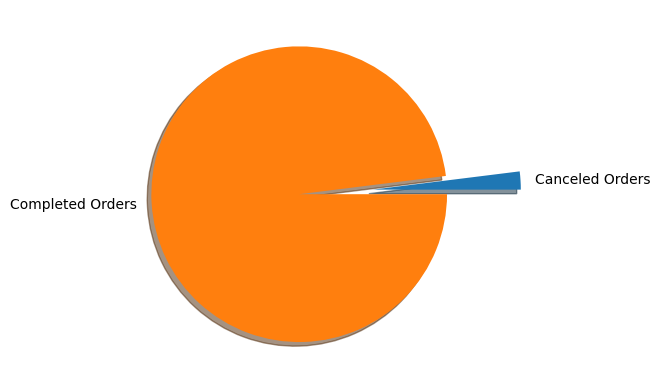

In [22]:
#Canceled transaction piechart analysis
sell_df = sorted_df[sorted_df.Quantity > 0]
labels = ['Canceled Orders', 'Completed Orders']
y= [len(canceled_filtered_df), len(sell_df)]
myexplode = [0.5, 0]
plt.pie(y, labels = labels, explode = myexplode, shadow = True)
plt.show()

Canceled orders donot contribute to actual revenue, so including them can skew metrics like total sales, average order value, and revenue forecasts. Excluding them provides a clearer picture of the financial health and performance of the business. So, we are going to ignore them.

In [37]:
sorted_df = sorted_df[sorted_df.Quantity > 0]
sorted_df = sorted_df[sorted_df.Price > 0]
sorted_df = sorted_df[sorted_df.Description != 'This is a test product.']

In [38]:
sorted_df.head(
)

Invoice StockCode                 Description  Quantity  \
107800  499763     20682  RED SPOTTY CHILDS UMBRELLA         1   
107801  499763     20679       EDWARDIAN PARASOL RED         1   
107802  499763    15056N   EDWARDIAN PARASOL NATURAL         1   
107803  499763   15056BL     EDWARDIAN PARASOL BLACK         1   
107804  499763    15056P      EDWARDIAN PARASOL PINK         1   

               InvoiceDate  Price Customer ID         Country  Revenue Quarter  
107800 2010-03-02 13:08:00   3.25     12346.0  United Kingdom     3.25  2010Q1  
107801 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95  2010Q1  
107802 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95  2010Q1  
107803 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95  2010Q1  
107804 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95  2010Q1

In [39]:
sorted_df['Revenue']= sorted_df['Quantity'] * sorted_df['Price']

In [40]:
spenders = sorted_df.groupby('Customer ID')['Revenue'].sum()
spenders

Customer ID
12346.0          169.36
12347.0         1323.32
12348.0          222.16
12349.0         2671.14
12351.0          300.93
                ...    
18284.0          461.68
18285.0          427.00
18286.0         1296.43
18287.0         2345.71
Anonymous    1473902.49
Name: Revenue, Length: 4313, dtype: float64

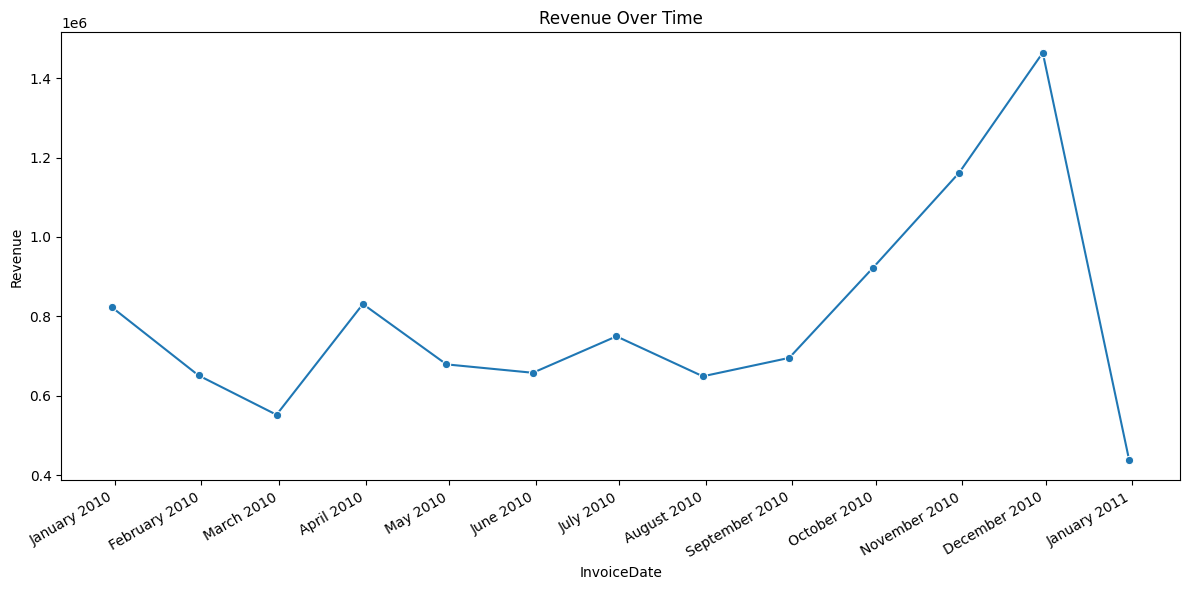

In [41]:
import matplotlib.dates as mdates


monthly_revenue = sorted_df.resample('M', on='InvoiceDate')['Revenue'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x='InvoiceDate', y='Revenue', marker='o')
plt.title('Revenue Over Time')

# Format the x-axis to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

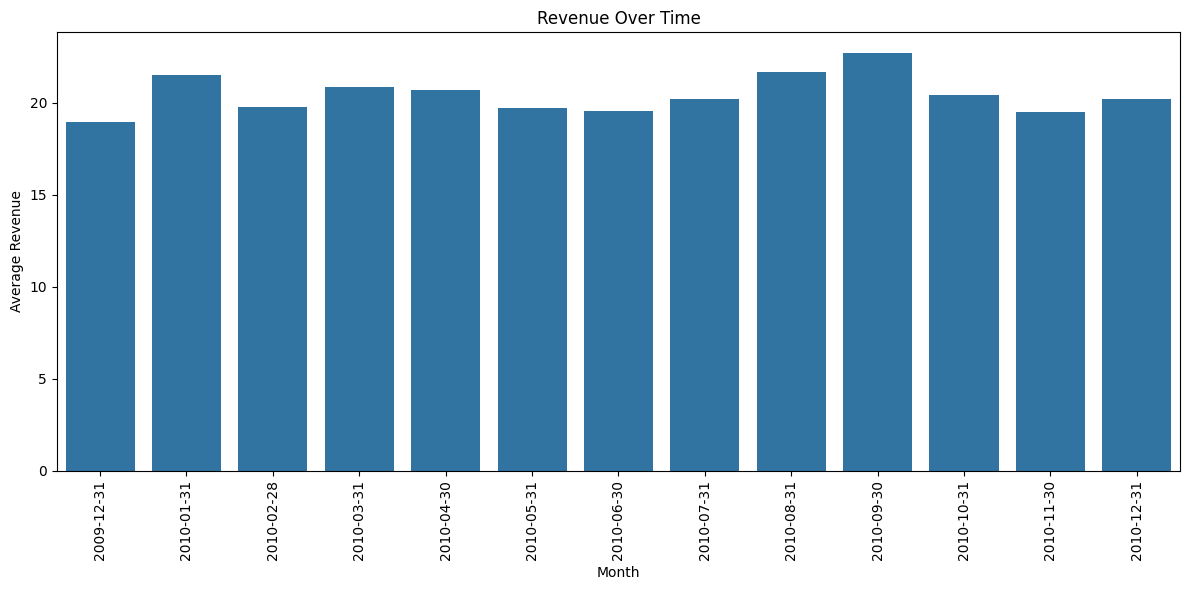

In [42]:
monthly_revenue = sorted_df.resample('M', on='InvoiceDate')['Revenue'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_revenue, x='InvoiceDate', y='Revenue')

# Title and labels
plt.title('Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.xticks(rotation = 90)

# Format the x-axis to show month names

plt.tight_layout()
plt.show()

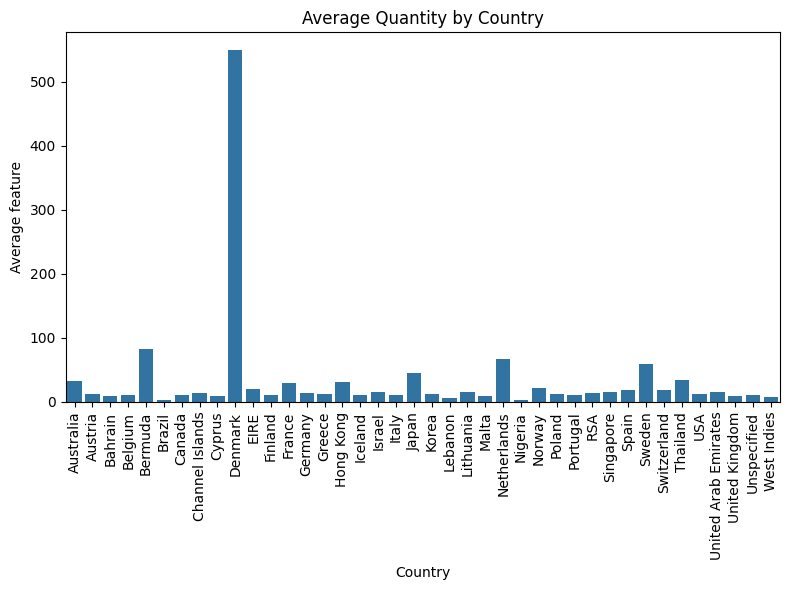

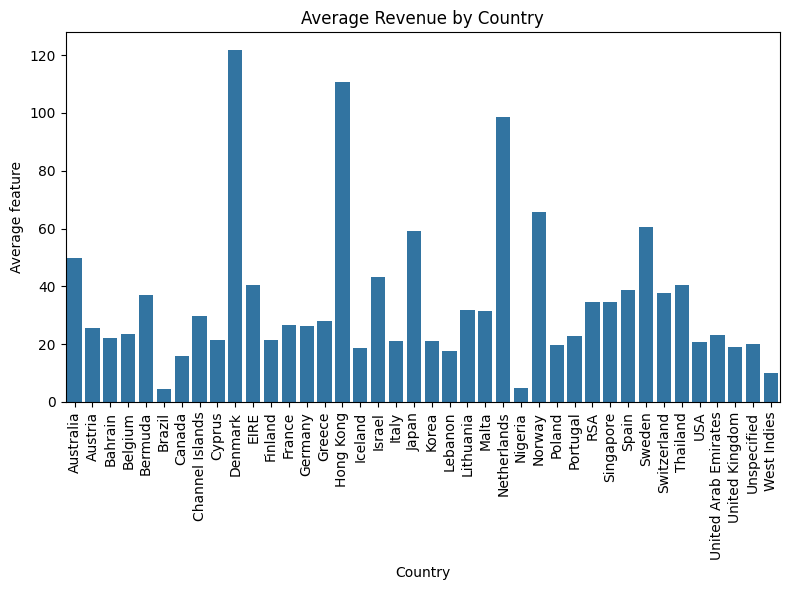

In [43]:
country_sales = sorted_df.groupby('Country')[['Quantity', 'Revenue']].mean().reset_index()
numerical_feature = ['Quantity', 'Revenue']
for feature in sorted_df[numerical_feature]:
  plt.figure(figsize=(8, 6))
  sns.barplot(data=country_sales, x='Country', y= feature)
  plt.xlabel('Country')
  plt.ylabel('Average feature')
  plt.title(f'Average {feature} by Country')
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

Denmark imports most item on average

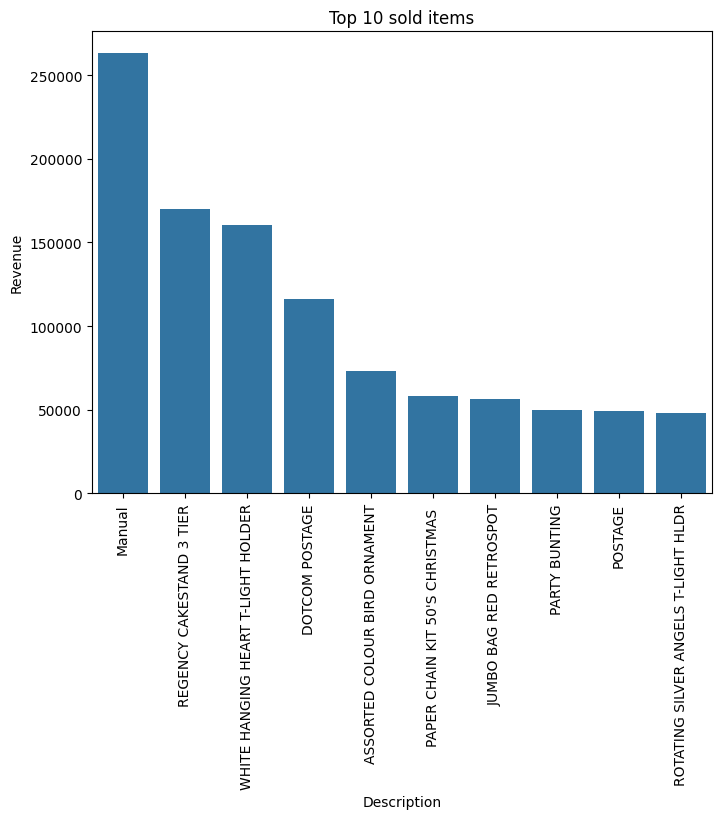

In [44]:
top_items = sorted_df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).reset_index()

top_items = top_items.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_items, x = 'Description', y = 'Revenue')
plt.xticks(rotation = 90)
plt.title('Top 10 sold items')
plt.show()

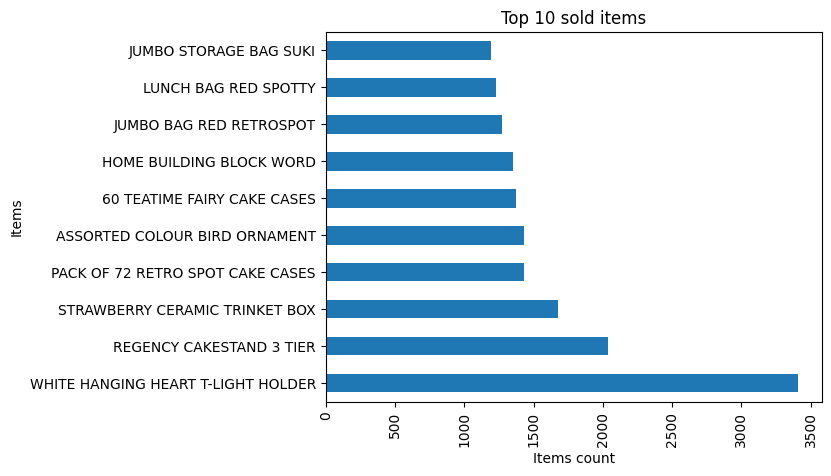

In [45]:
popular_items = sorted_df.groupby('Description').size().sort_values(ascending=False)
popular = popular_items.head(10)
popular.plot(kind = 'barh')
#plt.figure(figsize = (8,6))
plt.xticks(rotation = 90)
plt.xlabel('Items count')
plt.ylabel('Items')
plt.title('Top 10 sold items')
plt.show()

In [46]:
description_counts = sorted_df.groupby(['Country', 'Description']).size()
max_counts_idx = description_counts.groupby(level=0).idxmax()
best_sellers = description_counts.loc[max_counts_idx]
best_sellers_df = best_sellers.reset_index(name='Max_Count')

print(best_sellers_df) #Figuring out top sellers in each country

                 Country                         Description  Max_Count
0              Australia                 DOOR MAT UNION FLAG          5
1                Austria                             POSTAGE         18
2                Bahrain  SET/3 OCEAN SCENT CANDLE JEWEL BOX          3
3                Belgium                             POSTAGE         48
4                Bermuda   ASSORTED ICE CREAM FRIDGE MAGNETS          1
5                 Brazil       DOVE DECORATION PAINTED ZINC           2
6                 Canada       36 PENCILS TUBE RED RETROSPOT          1
7        Channel Islands            REGENCY CAKESTAND 3 TIER          7
8                 Cyprus  WHITE HANGING HEART T-LIGHT HOLDER          9
9                Denmark                             POSTAGE         10
10                  EIRE                            CARRIAGE         96
11               Finland                             POSTAGE          8
12                France                             POSTAGE    

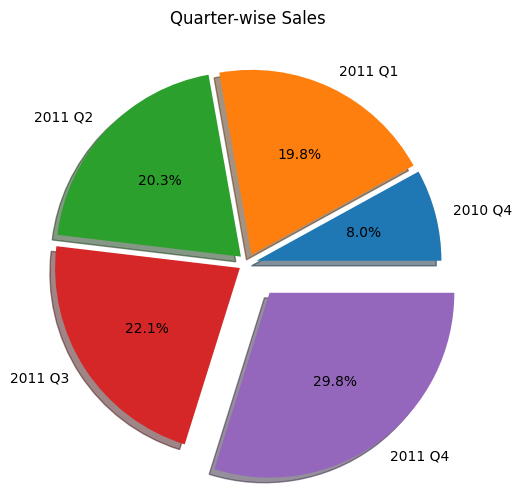

In [47]:
sorted_df["Quarter"] = pd.PeriodIndex(sorted_df["InvoiceDate"], freq= 'Q')
quarter_sales = sorted_df.groupby("Quarter")["Revenue"].sum()

plt.figure(figsize=(8, 6))
plt.pie(quarter_sales, labels = ["2010 Q4", "2011 Q1", "2011 Q2", "2011 Q3", "2011 Q4"], autopct = "%1.1f%%", explode = [0.05,0.05,0.05,0.05, 0.2],
        shadow = True)
plt.title("Quarter-wise Sales")
plt.show()
#quarter wise income chart with biggest slice in 2011 Q4. That mat be because
#of holiday season increasing the demand. Business doing much better to 2010 Q4.

Removing all negative canceled

#Cohort Analysis

In [48]:
cohort_df = sorted_df[sorted_df['Customer ID'] != 'Anonymous'] #cohort analysis

Including anonymous orders can introduce ambiguity into your analysis. If you can’t link an anonymous order to a specific customer. Hence, ignoring anonymous customer ID

In [49]:
cohort_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400906 entries, 107800 to 478769
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400906 non-null  object        
 1   StockCode    400906 non-null  object        
 2   Description  400906 non-null  object        
 3   Quantity     400906 non-null  int64         
 4   InvoiceDate  400906 non-null  datetime64[ns]
 5   Price        400906 non-null  float64       
 6   Customer ID  400906 non-null  object        
 7   Country      400906 non-null  object        
 8   Revenue      400906 non-null  float64       
 9   Quarter      400906 non-null  period[Q-DEC] 
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[Q-DEC](1)
memory usage: 33.6+ MB


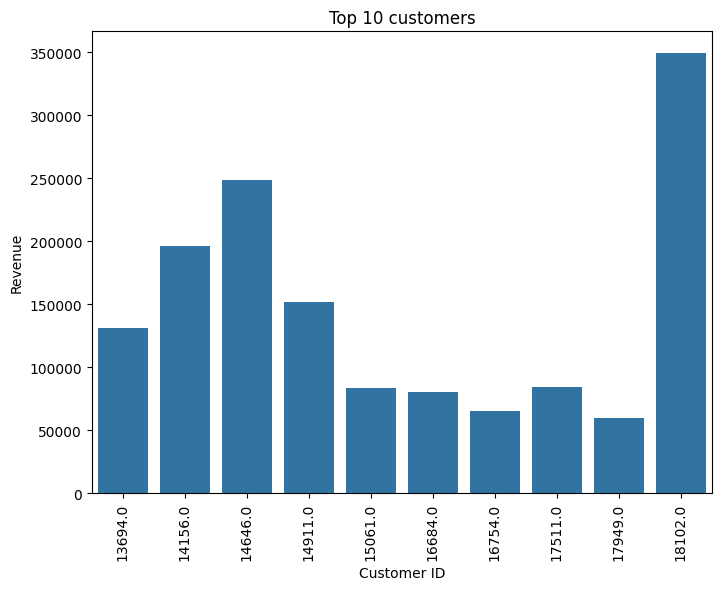

In [50]:
spenders = cohort_df.groupby('Customer ID')['Revenue'].sum().sort_values(ascending=False).reset_index()
top_spenders = spenders.head(10)

plt.figure(figsize = (8, 6))
sns.barplot(data = top_spenders, x = 'Customer ID', y = 'Revenue')
plt.xticks(rotation = 90)
plt.title('Top 10 customers')
plt.show()

#Cleaning Date

In [51]:
import datetime
cohort_df['Date']= cohort_df['InvoiceDate'].dt.strftime('%Y-%m')
cohort_df.info()

<ipython-input-51-9d0f4458d69a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
Index: 400906 entries, 107800 to 478769
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400906 non-null  object        
 1   StockCode    400906 non-null  object        
 2   Description  400906 non-null  object        
 3   Quantity     400906 non-null  int64         
 4   InvoiceDate  400906 non-null  datetime64[ns]
 5   Price        400906 non-null  float64       
 6   Customer ID  400906 non-null  object        
 7   Country      400906 non-null  object        
 8   Revenue      400906 non-null  float64       
 9   Quarter      400906 non-null  period[Q-DEC] 
 10  Date         400906 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6), period[Q-DEC](1)
memory usage: 36.7+ MB


In [52]:
cohort_df['Date'] = pd.to_datetime(cohort_df['Date'])
cohort_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400906 entries, 107800 to 478769
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400906 non-null  object        
 1   StockCode    400906 non-null  object        
 2   Description  400906 non-null  object        
 3   Quantity     400906 non-null  int64         
 4   InvoiceDate  400906 non-null  datetime64[ns]
 5   Price        400906 non-null  float64       
 6   Customer ID  400906 non-null  object        
 7   Country      400906 non-null  object        
 8   Revenue      400906 non-null  float64       
 9   Quarter      400906 non-null  period[Q-DEC] 
 10  Date         400906 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5), period[Q-DEC](1)
memory usage: 36.7+ MB


<ipython-input-52-2db6a005d199>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
cohort_df.tail()

Invoice StockCode                         Description  Quantity  \
478765  534346     22866       HAND WARMER SCOTTY DOG DESIGN        12   
478766  534346    85039A  SET/4 RED MINI ROSE CANDLE IN BOWL        48   
478767  534346    85039B  S/4 IVORY MINI ROSE CANDLE IN BOWL        48   
478768  534346    85040A     S/4 PINK FLOWER CANDLES IN BOWL        48   
478769  534346        C2                            CARRIAGE         1   

               InvoiceDate  Price Customer ID         Country  Revenue  \
478765 2010-11-22 11:51:00   2.10     18287.0  United Kingdom     25.2   
478766 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478767 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478768 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478769 2010-11-22 11:51:00  50.00     18287.0  United Kingdom     50.0   

       Quarter       Date  
478765  2010Q4 2010-11-01  
478766  2010Q4 2010-11-01  
478767  2010Q4 2010-11-01  
478768  2010Q4 2010-11-01  
478769  2010Q4 2010-11-01

In [54]:
cohort_df.duplicated().sum()

0

In [55]:
#create a column index with minimum invoice date for first time customer
cohort_df['Cohort Month'] = cohort_df.groupby('Customer ID')['Date'].transform('min')
cohort_df.head(15)

<ipython-input-55-3170d2294df1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Invoice StockCode                         Description  Quantity  \
107800  499763     20682          RED SPOTTY CHILDS UMBRELLA         1   
107801  499763     20679               EDWARDIAN PARASOL RED         1   
107802  499763    15056N           EDWARDIAN PARASOL NATURAL         1   
107803  499763   15056BL             EDWARDIAN PARASOL BLACK         1   
107804  499763    15056P              EDWARDIAN PARASOL PINK         1   
253028  513774     21524      DOORMAT SPOTTY HOME SWEET HOME         1   
253029  513774     22692         DOORMAT WELCOME TO OUR HOME         1   
253030  513774     22660               DOORMAT I LOVE LONDON         1   
253031  513774     22687           DOORMAT CHRISTMAS VILLAGE         1   
253032  513774    48173C                DOORMAT BLACK FLOCK          1   
253033  513774     22691             DOORMAT WELCOME SUNRISE         1   
253034  513774     48111               DOORMAT 3 SMILEY CATS         1   
253035  513774     22690       DOORMAT HOME SWEET HOME BLUE          1   
253036  513774     21523  DOORMAT FANCY FONT HOME SWEET HOME         1   
253037  513774     48138                  DOORMAT UNION FLAG         1   

               InvoiceDate  Price Customer ID         Country  Revenue  \
107800 2010-03-02 13:08:00   3.25     12346.0  United Kingdom     3.25   
107801 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
107802 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
107803 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
107804 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
253028 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253029 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253030 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253031 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253032 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253033 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253034 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253035 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253036 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   
253037 2010-06-28 13:53:00   7.49     12346.0  United Kingdom     7.49   

       Quarter       Date Cohort Month  
107800  2010Q1 2010-03-01   2010-03-01  
107801  2010Q1 2010-03-01   2010-03-01  
107802  2010Q1 2010-03-01   2010-03-01  
107803  2010Q1 2010-03-01   2010-03-01  
107804  2010Q1 2010-03-01   2010-03-01  
253028  2010Q2 2010-06-01   2010-03-01  
253029  2010Q2 2010-06-01   2010-03-01  
253030  2010Q2 2010-06-01   2010-03-01  
253031  2010Q2 2010-06-01   2010-03-01  
253032  2010Q2 2010-06-01   2010-03-01  
253033  2010Q2 2010-06-01   2010-03-01  
253034  2010Q2 2010-06-01   2010-03-01  
253035  2010Q2 2010-06-01   2010-03-01  
253036  2010Q2 2010-06-01   2010-03-01  
253037  2010Q2 2010-06-01   2010-03-01

In [56]:
cohort_df.tail()

Invoice StockCode                         Description  Quantity  \
478765  534346     22866       HAND WARMER SCOTTY DOG DESIGN        12   
478766  534346    85039A  SET/4 RED MINI ROSE CANDLE IN BOWL        48   
478767  534346    85039B  S/4 IVORY MINI ROSE CANDLE IN BOWL        48   
478768  534346    85040A     S/4 PINK FLOWER CANDLES IN BOWL        48   
478769  534346        C2                            CARRIAGE         1   

               InvoiceDate  Price Customer ID         Country  Revenue  \
478765 2010-11-22 11:51:00   2.10     18287.0  United Kingdom     25.2   
478766 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478767 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478768 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478769 2010-11-22 11:51:00  50.00     18287.0  United Kingdom     50.0   

       Quarter       Date Cohort Month  
478765  2010Q4 2010-11-01   2010-05-01  
478766  2010Q4 2010-11-01   2010-05-01  
478767  2010Q4 2010-11-01   2010-05-01  
478768  2010Q4 2010-11-01   2010-05-01  
478769  2010Q4 2010-11-01   2010-05-01

In [57]:
import datetime
def get_date(df, column):
  day = df[column].dt.day
  month = df[column].dt.month
  year = df[column].dt.year
  return day, month, year

In [58]:
_,Invoice_Month,Invoice_Year = get_date(cohort_df, 'Date')
_,Cohort_Month,Cohort_Year = get_date(cohort_df, 'Cohort Month')

In [59]:
Year_diff = Invoice_Year - Cohort_Year
Month_diff = Invoice_Month - Cohort_Month
cohort_df['CohortIndex'] = Year_diff*12 + Month_diff + 1
cohort_df.head()

<ipython-input-59-f651a7732f56>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Invoice StockCode                 Description  Quantity  \
107800  499763     20682  RED SPOTTY CHILDS UMBRELLA         1   
107801  499763     20679       EDWARDIAN PARASOL RED         1   
107802  499763    15056N   EDWARDIAN PARASOL NATURAL         1   
107803  499763   15056BL     EDWARDIAN PARASOL BLACK         1   
107804  499763    15056P      EDWARDIAN PARASOL PINK         1   

               InvoiceDate  Price Customer ID         Country  Revenue  \
107800 2010-03-02 13:08:00   3.25     12346.0  United Kingdom     3.25   
107801 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
107802 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
107803 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   
107804 2010-03-02 13:08:00   5.95     12346.0  United Kingdom     5.95   

       Quarter       Date Cohort Month  CohortIndex  
107800  2010Q1 2010-03-01   2010-03-01            1  
107801  2010Q1 2010-03-01   2010-03-01            1  
107802  2010Q1 2010-03-01   2010-03-01            1  
107803  2010Q1 2010-03-01   2010-03-01            1  
107804  2010Q1 2010-03-01   2010-03-01            1

In [60]:
cohort_df.tail()

Invoice StockCode                         Description  Quantity  \
478765  534346     22866       HAND WARMER SCOTTY DOG DESIGN        12   
478766  534346    85039A  SET/4 RED MINI ROSE CANDLE IN BOWL        48   
478767  534346    85039B  S/4 IVORY MINI ROSE CANDLE IN BOWL        48   
478768  534346    85040A     S/4 PINK FLOWER CANDLES IN BOWL        48   
478769  534346        C2                            CARRIAGE         1   

               InvoiceDate  Price Customer ID         Country  Revenue  \
478765 2010-11-22 11:51:00   2.10     18287.0  United Kingdom     25.2   
478766 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478767 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478768 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478769 2010-11-22 11:51:00  50.00     18287.0  United Kingdom     50.0   

       Quarter       Date Cohort Month  CohortIndex  
478765  2010Q4 2010-11-01   2010-05-01            7  
478766  2010Q4 2010-11-01   2010-05-01            7  
478767  2010Q4 2010-11-01   2010-05-01            7  
478768  2010Q4 2010-11-01   2010-05-01            7  
478769  2010Q4 2010-11-01   2010-05-01            7

In [62]:
cohort_summary = cohort_df.groupby(['Cohort Month', 'CohortIndex'])['Customer ID'].nunique().reset_index()
cohort_summary

Cohort Month  CohortIndex  Customer ID
0    2009-12-01            1          954
1    2009-12-01            2          336
2    2009-12-01            3          319
3    2009-12-01            4          405
4    2009-12-01            5          363
..          ...          ...          ...
86   2010-10-01            2           97
87   2010-10-01            3           35
88   2010-11-01            1          325
89   2010-11-01            2           35
90   2010-12-01            1           46

[91 rows x 3 columns]

In [64]:
pivot_cohort = cohort_summary.pivot(index = 'Cohort Month', columns = ['CohortIndex'], values ='Customer ID')
pivot_cohort #pivot chart

CohortIndex      1      2      3      4      5      6      7      8      9   \
Cohort Month                                                                  
2009-12-01    954.0  336.0  319.0  405.0  363.0  343.0  359.0  327.0  321.0   
2010-01-01    383.0   79.0  119.0  117.0  101.0  115.0   99.0   88.0  107.0   
2010-02-01    374.0   89.0   84.0  109.0   92.0   75.0   72.0  107.0   95.0   
2010-03-01    444.0   84.0  102.0  108.0  103.0   90.0  109.0  134.0  122.0   
2010-04-01    294.0   57.0   57.0   48.0   54.0   66.0   81.0   77.0   20.0   
2010-05-01    254.0   40.0   43.0   44.0   45.0   65.0   54.0   20.0    NaN   
2010-06-01    270.0   47.0   51.0   55.0   62.0   77.0   18.0    NaN    NaN   
2010-07-01    186.0   29.0   34.0   55.0   54.0   19.0    NaN    NaN    NaN   
2010-08-01    162.0   33.0   48.0   52.0   19.0    NaN    NaN    NaN    NaN   
2010-09-01    243.0   55.0   57.0   24.0    NaN    NaN    NaN    NaN    NaN   
2010-10-01    377.0   97.0   35.0    NaN    NaN    NaN    NaN    NaN    NaN   
2010-11-01    325.0   35.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-12-01     46.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex      10     11     12     13  
Cohort Month                              
2009-12-01    346.0  403.0  473.0  237.0  
2010-01-01    122.0  116.0   38.0    NaN  
2010-02-01    103.0   27.0    NaN    NaN  
2010-03-01     35.0    NaN    NaN    NaN  
2010-04-01      NaN    NaN    NaN    NaN  
2010-05-01      NaN    NaN    NaN    NaN  
2010-06-01      NaN    NaN    NaN    NaN  
2010-07-01      NaN    NaN    NaN    NaN  
2010-08-01      NaN    NaN    NaN    NaN  
2010-09-01      NaN    NaN    NaN    NaN  
2010-10-01      NaN    NaN    NaN    NaN  
2010-11-01      NaN    NaN    NaN    NaN  
2010-12-01      NaN    NaN    NaN    NaN

In [65]:
pivot_cohort.index = pivot_cohort.index.to_period('M').strftime('%Y-%m') #need to edit

In [66]:
percent_cohort = pivot_cohort.divide(pivot_cohort.iloc[:, 0], axis = 0)
percent_cohort

CohortIndex    1         2         3         4         5         6         7   \
Cohort Month                                                                    
2009-12       1.0  0.352201  0.334382  0.424528  0.380503  0.359539  0.376310   
2010-01       1.0  0.206266  0.310705  0.305483  0.263708  0.300261  0.258486   
2010-02       1.0  0.237968  0.224599  0.291444  0.245989  0.200535  0.192513   
2010-03       1.0  0.189189  0.229730  0.243243  0.231982  0.202703  0.245495   
2010-04       1.0  0.193878  0.193878  0.163265  0.183673  0.224490  0.275510   
2010-05       1.0  0.157480  0.169291  0.173228  0.177165  0.255906  0.212598   
2010-06       1.0  0.174074  0.188889  0.203704  0.229630  0.285185  0.066667   
2010-07       1.0  0.155914  0.182796  0.295699  0.290323  0.102151       NaN   
2010-08       1.0  0.203704  0.296296  0.320988  0.117284       NaN       NaN   
2010-09       1.0  0.226337  0.234568  0.098765       NaN       NaN       NaN   
2010-10       1.0  0.257294  0.092838       NaN       NaN       NaN       NaN   
2010-11       1.0  0.107692       NaN       NaN       NaN       NaN       NaN   
2010-12       1.0       NaN       NaN       NaN       NaN       NaN       NaN   

CohortIndex         8         9         10        11        12        13  
Cohort Month                                                              
2009-12       0.342767  0.336478  0.362683  0.422432  0.495807  0.248428  
2010-01       0.229765  0.279373  0.318538  0.302872  0.099217       NaN  
2010-02       0.286096  0.254011  0.275401  0.072193       NaN       NaN  
2010-03       0.301802  0.274775  0.078829       NaN       NaN       NaN  
2010-04       0.261905  0.068027       NaN       NaN       NaN       NaN  
2010-05       0.078740       NaN       NaN       NaN       NaN       NaN  
2010-06            NaN       NaN       NaN       NaN       NaN       NaN  
2010-07            NaN       NaN       NaN       NaN       NaN       NaN  
2010-08            NaN       NaN       NaN       NaN       NaN       NaN  
2010-09            NaN       NaN       NaN       NaN       NaN       NaN  
2010-10            NaN       NaN       NaN       NaN       NaN       NaN  
2010-11            NaN       NaN       NaN       NaN       NaN       NaN  
2010-12            NaN       NaN       NaN       NaN       NaN       NaN

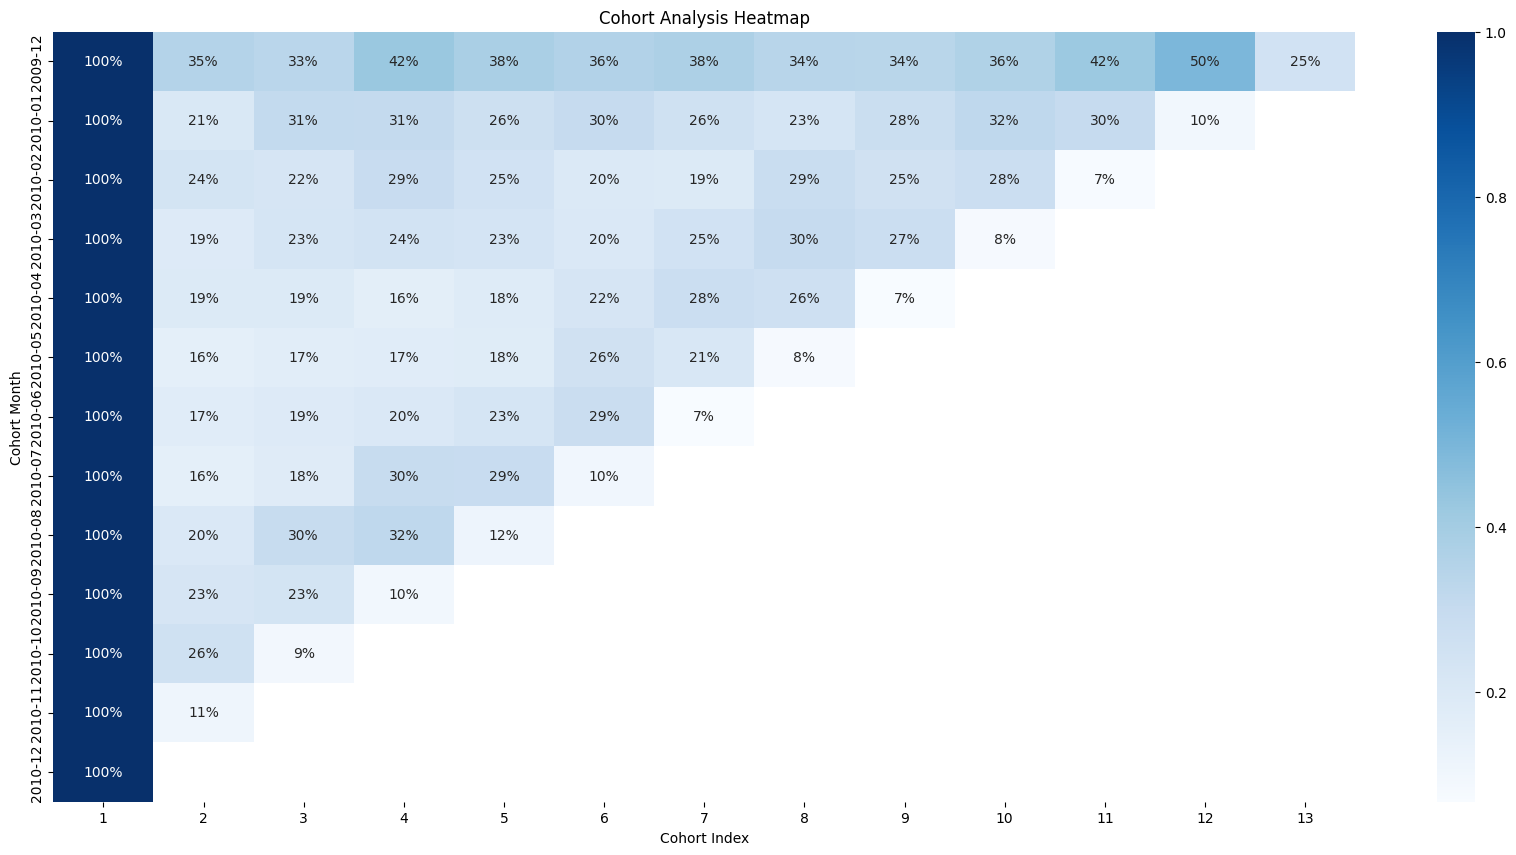

In [67]:
plt.figure(figsize= (21, 10))
sns.heatmap(percent_cohort, annot= True, cmap= 'Blues', fmt='.0%')
plt.yticks(rotation=90)
plt.title('Cohort Analysis Heatmap')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')

plt.show()

We were successfully maintaining our wholesalers' satisfaction, with a retention rate between 38% and 50%. However, recently, this rate has fallen to single digits indicates potential issues that need to be addressed.


*  We need to understand why retention has declined. Gathering feedback from wholesalers and analyzing customer service interactions could provide valuable insights.
*   assess whether competitors are offering better terms or services, as this could be influencing our wholesalers' decisions.




#Net Revenue Retention

In [68]:
cohort_df['Revenue'] = cohort_df['Quantity'] * cohort_df['Price']
cohort_df.tail()

<ipython-input-68-19fab0aef4ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Invoice StockCode                         Description  Quantity  \
478765  534346     22866       HAND WARMER SCOTTY DOG DESIGN        12   
478766  534346    85039A  SET/4 RED MINI ROSE CANDLE IN BOWL        48   
478767  534346    85039B  S/4 IVORY MINI ROSE CANDLE IN BOWL        48   
478768  534346    85040A     S/4 PINK FLOWER CANDLES IN BOWL        48   
478769  534346        C2                            CARRIAGE         1   

               InvoiceDate  Price Customer ID         Country  Revenue  \
478765 2010-11-22 11:51:00   2.10     18287.0  United Kingdom     25.2   
478766 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478767 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478768 2010-11-22 11:51:00   1.45     18287.0  United Kingdom     69.6   
478769 2010-11-22 11:51:00  50.00     18287.0  United Kingdom     50.0   

       Quarter       Date Cohort Month  CohortIndex  
478765  2010Q4 2010-11-01   2010-05-01            7  
478766  2010Q4 2010-11-01   2010-05-01            7  
478767  2010Q4 2010-11-01   2010-05-01            7  
478768  2010Q4 2010-11-01   2010-05-01            7  
478769  2010Q4 2010-11-01   2010-05-01            7

In [69]:
cohort_revenue_summary = cohort_df.groupby(['Cohort Month', 'CohortIndex'])['Revenue'].sum().reset_index()
cohort_revenue_summary.columns = ['Cohort Month', 'CohortIndex', 'Total Revenue']
cohort_revenue_summary

Cohort Month  CohortIndex  Total Revenue
0    2009-12-01            1     683390.510
1    2009-12-01            2     394633.981
2    2009-12-01            3     295931.572
3    2009-12-01            4     378636.070
4    2009-12-01            5     305901.290
..          ...          ...            ...
86   2010-10-01            2      46538.180
87   2010-10-01            3      10172.250
88   2010-11-01            1     152555.110
89   2010-11-01            2      12049.900
90   2010-12-01            1      12709.190

[91 rows x 3 columns]

In [70]:
pivot_cohort_revenue = cohort_revenue_summary.pivot(index = 'Cohort Month', columns = ['CohortIndex'], values ='Total Revenue')
pivot_cohort_revenue

CohortIndex           1           2           3           4          5   \
Cohort Month                                                              
2009-12-01    683390.510  394633.981  295931.572  378636.070  305901.29   
2010-01-01    161078.691   38985.350   50955.470   57400.211   58528.89   
2010-02-01    169642.034   33174.620   54677.760   53236.910   43906.71   
2010-03-01    234212.311   49737.450   51722.750   64649.940   50115.97   
2010-04-01    124242.791   18871.040   20579.410   30099.750   22224.76   
2010-05-01    110407.130   13574.650   14065.400   12685.680   16861.31   
2010-06-01    131044.360   16038.770   22546.500   25780.810   34934.40   
2010-07-01     75047.650    8384.300   13690.610   24927.850   28658.50   
2010-08-01     60663.300   13797.990   23029.070   23403.830    8154.47   
2010-09-01    159647.200   29633.550   32174.950    9243.340        NaN   
2010-10-01    185266.870   46538.180   10172.250         NaN        NaN   
2010-11-01    152555.110   12049.900         NaN         NaN        NaN   
2010-12-01     12709.190         NaN         NaN         NaN        NaN   

CohortIndex          6          7           8          9          10  \
Cohort Month                                                           
2009-12-01    305066.66  301820.97  312812.830  331787.09  391539.48   
2010-01-01     60795.09   51990.10   48004.070   60459.54   74544.04   
2010-02-01     39565.70   40078.67   51089.571   52810.88   54630.03   
2010-03-01     55850.23   65378.39   81126.030   76267.27   13995.03   
2010-04-01     30769.05   35105.30   32670.450    4979.15        NaN   
2010-05-01     31174.36   23140.53    4575.610        NaN        NaN   
2010-06-01     48306.23    9299.55         NaN        NaN        NaN   
2010-07-01      6791.62        NaN         NaN        NaN        NaN   
2010-08-01          NaN        NaN         NaN        NaN        NaN   
2010-09-01          NaN        NaN         NaN        NaN        NaN   
2010-10-01          NaN        NaN         NaN        NaN        NaN   
2010-11-01          NaN        NaN         NaN        NaN        NaN   
2010-12-01          NaN        NaN         NaN        NaN        NaN   

CohortIndex          11          12         13  
Cohort Month                                    
2009-12-01    460559.66  571512.942  184672.14  
2010-01-01     76602.00   21991.750        NaN  
2010-02-01     12022.37         NaN        NaN  
2010-03-01          NaN         NaN        NaN  
2010-04-01          NaN         NaN        NaN  
2010-05-01          NaN         NaN        NaN  
2010-06-01          NaN         NaN        NaN  
2010-07-01          NaN         NaN        NaN  
2010-08-01          NaN         NaN        NaN  
2010-09-01          NaN         NaN        NaN  
2010-10-01          NaN         NaN        NaN  
2010-11-01          NaN         NaN        NaN  
2010-12-01          NaN         NaN        NaN

In [ ]:
pivot_cohort_revenue.index = pivot_cohort_revenue.index.strftime('%B %Y')

In [ ]:
percent_cohort_revnue = pivot_cohort_revenue.divide(pivot_cohort_revenue.iloc[:, 0], axis = 0)
percent_cohort_revnue

CohortIndex      1         2         3         4         5         6   \
Cohort Month                                                            
December 2009   1.0  0.577465  0.433034  0.554055  0.447623  0.446402   
January 2010    1.0  0.242027  0.316339  0.356349  0.363356  0.377425   
February 2010   1.0  0.195557  0.322313  0.313819  0.258820  0.233231   
March 2010      1.0  0.212361  0.220837  0.276031  0.213977  0.238460   
April 2010      1.0  0.151888  0.165639  0.242266  0.178882  0.247653   
May 2010        1.0  0.122951  0.127396  0.114899  0.152719  0.282358   
June 2010       1.0  0.122392  0.172052  0.196733  0.266585  0.368625   
July 2010       1.0  0.111720  0.182426  0.332160  0.381871  0.090497   
August 2010     1.0  0.227452  0.379621  0.385799  0.134422       NaN   
September 2010  1.0  0.185619  0.201538  0.057899       NaN       NaN   
October 2010    1.0  0.251195  0.054906       NaN       NaN       NaN   
November 2010   1.0  0.078987       NaN       NaN       NaN       NaN   
December 2010   1.0       NaN       NaN       NaN       NaN       NaN   

CohortIndex           7         8         9         10        11        12  \
Cohort Month                                                                 
December 2009   0.441652  0.457737  0.485501  0.572937  0.673933  0.836290   
January 2010    0.322762  0.298016  0.375342  0.462780  0.475556  0.136528   
February 2010   0.236254  0.301161  0.311308  0.322031  0.070869       NaN   
March 2010      0.279142  0.346378  0.325633  0.059754       NaN       NaN   
April 2010      0.282554  0.262957  0.040076       NaN       NaN       NaN   
May 2010        0.209593  0.041443       NaN       NaN       NaN       NaN   
June 2010       0.070965       NaN       NaN       NaN       NaN       NaN   
July 2010            NaN       NaN       NaN       NaN       NaN       NaN   
August 2010          NaN       NaN       NaN       NaN       NaN       NaN   
September 2010       NaN       NaN       NaN       NaN       NaN       NaN   
October 2010         NaN       NaN       NaN       NaN       NaN       NaN   
November 2010        NaN       NaN       NaN       NaN       NaN       NaN   
December 2010        NaN       NaN       NaN       NaN       NaN       NaN   

CohortIndex           13  
Cohort Month              
December 2009   0.270229  
January 2010         NaN  
February 2010        NaN  
March 2010           NaN  
April 2010           NaN  
May 2010             NaN  
June 2010            NaN  
July 2010            NaN  
August 2010          NaN  
September 2010       NaN  
October 2010         NaN  
November 2010        NaN  
December 2010        NaN

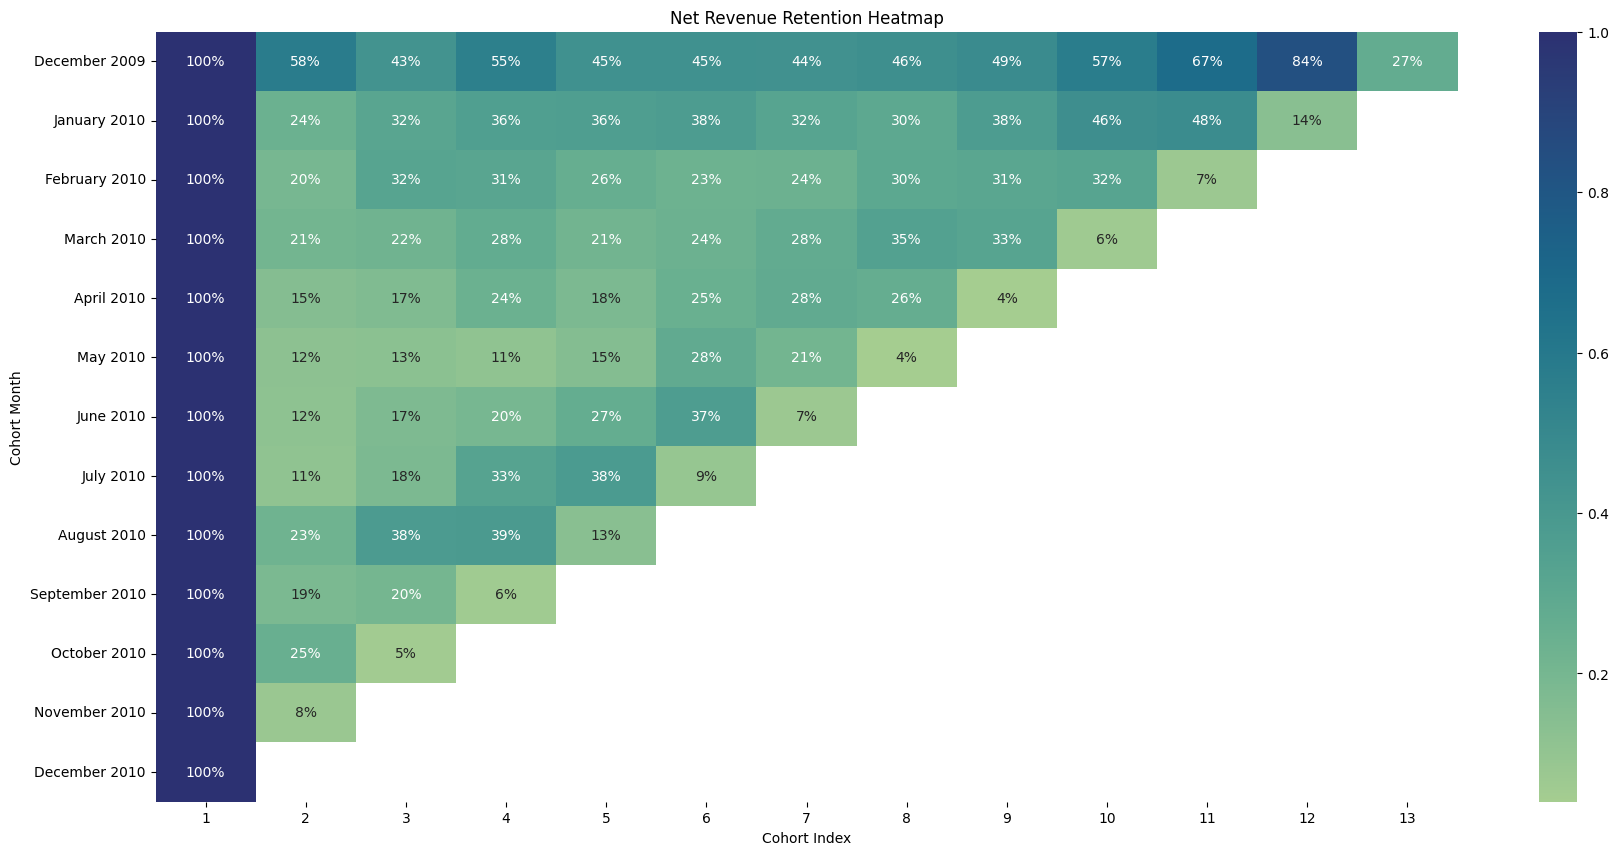

In [ ]:
plt.figure(figsize= (21, 10))
sns.heatmap(percent_cohort_revnue, annot= True, cmap= 'crest', fmt='.0%')
#plt.yticks(rotation=90)
plt.title('Net Revenue Retention Heatmap')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')

plt.show()

Revenue retention was strong until last month, but it has now dropped significantly into single digits, indicating a troubling trend. We need to address this issue urgently to understand the underlying causes and implement effective strategies for recovery.





While quarterly sales are performing well, we’re seeing a decrease in retention rates. This discrepancy suggests that although we’re attracting new customers or making larger sales, we may be struggling to keep existing customers engaged. It’s important to investigate the reasons behind the decline in retention

#Customer Lifetime Value

In [71]:
def get_CLV_table(df):
  max_date = df['Date'].max()
  df = df.groupby(['Customer ID']).agg(
    {'Date' : lambda x: (max_date - x.min()).days,
     #'Date' : lambda x: (max_date - x.max()).days,
     'Invoice': lambda x: x.nunique(),
     'Quantity': lambda x: x.sum(),
     'Revenue': lambda x: x.sum()
    }
   )
  return df
#CLV_df.rename(columns={'Revenue': 'Total_Revenue'}, inplace=True)


In [74]:
CLV_df = get_CLV_table(cohort_df).reset_index()
CLV_df.rename(columns={'Invoice': 'Frequency', 'Revenue': 'Total_Revenue'}, inplace=True)
CLV_df.head()

Customer ID  Date  Frequency  Quantity  Total_Revenue
0      12346.0   275          2        24         169.36
1      12347.0    61          2       828        1323.32
2      12348.0    91          1       373         222.16
3      12349.0   244          3       993        2671.14
4      12351.0    30          1       261         300.93

In [75]:
CLV_df['AOV'] = CLV_df['Total_Revenue']/CLV_df['Frequency']
CLV_df

Customer ID  Date  Frequency  Quantity  Total_Revenue         AOV
0         12346.0   275          2        24         169.36   84.680000
1         12347.0    61          2       828        1323.32  661.660000
2         12348.0    91          1       373         222.16  222.160000
3         12349.0   244          3       993        2671.14  890.380000
4         12351.0    30          1       261         300.93  300.930000
...           ...   ...        ...       ...            ...         ...
4307      18283.0   303          6       322         619.37  103.228333
4308      18284.0    61          1       494         461.68  461.680000
4309      18285.0   303          1       145         427.00  427.000000
4310      18286.0   365          2       608        1296.43  648.215000
4311      18287.0   214          4      1427        2345.71  586.427500

[4312 rows x 6 columns]

In [76]:
def calculate_churn_rate(df, start_date, end_date):
    # Convert 'Date' to datetime if it's not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter data for the period
    period_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Number of customers at the start of the period
    start_customers = df[df['Date'] == start_date]['Customer ID'].nunique()

    # Number of customers who left during the period
    end_customers = df[df['Date'] == end_date]['Customer ID'].nunique()

    churned_customers = start_customers - end_customers

    churn_rate = (churned_customers / start_customers) * 100

    return churn_rate

In [77]:
churn_rate = calculate_churn_rate(cohort_df, cohort_df['Date'].min(), cohort_df['Date'].max())
print(f'Churn Rate: {churn_rate:.2f}%')

Churn Rate: 39.94%


<ipython-input-76-cfe464b688db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A 39.4% churn rate is high, we aren't able to keep majority of our customer on long term.

In [78]:
purchase_freq = CLV_df['Frequency'].mean()
purchase_freq

4.453385899814471

In [79]:
CLV_df['CLV'] = ((CLV_df['AOV'] * purchase_freq )/ churn_rate)
CLV_df.head()

Customer ID  Date  Frequency  Quantity  Total_Revenue     AOV        CLV
0      12346.0   275          2        24         169.36   84.68   9.442665
1      12347.0    61          2       828        1323.32  661.66  73.781692
2      12348.0    91          1       373         222.16  222.16  24.773057
3      12349.0   244          3       993        2671.14  890.38  99.286254
4      12351.0    30          1       261         300.93  300.93  33.556698

In [80]:
CLV_df.tail()

Customer ID  Date  Frequency  Quantity  Total_Revenue         AOV  \
4307      18283.0   303          6       322         619.37  103.228333   
4308      18284.0    61          1       494         461.68  461.680000   
4309      18285.0   303          1       145         427.00  427.000000   
4310      18286.0   365          2       608        1296.43  648.215000   
4311      18287.0   214          4      1427        2345.71  586.427500   

            CLV  
4307  11.510989  
4308  51.481926  
4309  47.614760  
4310  72.282440  
4311  65.392517

In [81]:
print(f'The median CLV is: {CLV_df["CLV"].median()}')
print(f'The mean CLV is: {CLV_df["CLV"].mean()}')

The median CLV is: 31.785733278855563
The mean CLV is: 41.97042776001914


Mean CLV (41.97): suggests that, on average, customers are expected to generate about $41.97 in revenue over their lifetime.
Median CLV (31.79): The median is lower, indicating that while some customers are generating high value, a significant number are contributing less. This discrepancy may suggest a long tail of lower-value customers.

In [82]:
max_date = cohort_df['Date'].max()
max_date

Timestamp('2010-12-01 00:00:00')

#RFM Analysis

In [83]:
def get_rfm_table(df):
  max_date = df['Date'].max()
  df = df.groupby(['Customer ID']).agg(
    {
     'Date' : lambda x: (max_date - x.max()).days + 1,
     'Invoice': lambda x: len(x),
     'Revenue': lambda x: x.sum()
    }
   )
  return df

In [84]:
rfm = get_rfm_table(cohort_df).reset_index()
rfm.rename(columns = {
    'Date' : 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'Monetary'
}, inplace = True)

In [85]:
rfm.head()

Customer ID  Recency  Frequency  Monetary
0      12346.0      184         24    169.36
1      12347.0        1         71   1323.32
2      12348.0       92         20    222.16
3      12349.0       62        102   2671.14
4      12351.0       31         21    300.93

In [86]:
rfm.duplicated().sum()

0

In [87]:
rfm.describe().T

count          mean          std       min        25%  \
Customer ID  4312.0  15349.290353  1701.200176  12346.00  13882.500   
Recency      4312.0     97.514610    97.338437      1.00     31.000   
Frequency    4312.0     92.974490   198.910049      1.00     18.000   
Monetary     4312.0   2040.354301  8911.766536      1.55    307.115   

                   50%         75%        max  
Customer ID  15350.500  16834.2500   18287.00  
Recency         62.000    154.0000     366.00  
Frequency       43.000    100.0000    5568.00  
Monetary       701.615   1714.9325  349164.35

In [88]:
rfm['RecencyScore'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=range(5, 0,-1), duplicates = 'drop')
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=range(1, 6), duplicates = 'drop')
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=range(1, 6), duplicates = 'drop') #assigning scores based on RFM from 1 to 5

In [89]:
rfm.head(25)

Customer ID  Recency  Frequency  Monetary RecencyScore FrequencyScore  \
0       12346.0      184         24    169.36            2              2   
1       12347.0        1         71   1323.32            5              4   
2       12348.0       92         20    222.16            3              2   
3       12349.0       62        102   2671.14            3              4   
4       12351.0       31         21    300.93            5              2   
5       12352.0       31         18    343.80            5              2   
6       12353.0       62         20    317.76            3              2   
7       12355.0      215         22    488.21            1              2   
8       12356.0       31         83   3560.30            5              4   
9       12357.0       31        165  12079.99            5              5   
10      12358.0       31         58   2719.01            5              3   
11      12359.0       62        117   2563.36            3              4   
12      12360.0       31         88   1590.83            5              4   
13      12361.0       92         19    321.35            3              2   
14      12362.0      366          1    130.00            1              1   
15      12366.0      276          3    500.24            1              1   
16      12368.0      276         18    917.70            1              2   
17      12369.0       62         93   1791.15            3              4   
18      12370.0      276         35    774.62            1              3   
19      12371.0       62        104   2179.42            3              4   
20      12373.0      276         37    763.05            1              3   
21      12374.0       62         50   2246.29            3              3   
22      12376.0       31         13    503.15            5              1   
23      12377.0       31         75   1798.20            5              4   
24      12378.0      215         82   1407.70            1              4   

   MonetaryScore  
0              1  
1              4  
2              1  
3              5  
4              2  
5              2  
6              2  
7              2  
8              5  
9              5  
10             5  
11             5  
12             4  
13             2  
14             1  
15             3  
16             3  
17             4  
18             3  
19             5  
20             3  
21             5  
22             3  
23             4  
24             4

In [90]:
rfm['Segment'] = (rfm['RecencyScore'].astype(str) +
rfm['FrequencyScore'].astype(str) +
rfm['MonetaryScore'].astype(str)) #combinig rfm score together

In [91]:
def define_segment(segment_code):
    segment_labels = {
        '555': 'Top Customers',
        '55*': 'High Value and Frequent',
        '54*': 'High Value but Less Frequent',
        '5*5': 'High Value but Less Frequent',
        '5*4': 'High Value but Less Frequent',
        '45*': 'Frequent but Moderate Value',
        '4*5': 'Frequent but Moderate Value',
        '44*': 'Moderate Value and Frequency',
        '2*': 'At risk',
        '1*': 'Churned'
    }

    for pattern, label in segment_labels.items():
        if segment_code == pattern.replace('*', '') or \
           (segment_code.startswith(pattern.replace('*', '')) and len(segment_code) == 3):
            return label

    # If no match is found, return 'Other'
    return 'Other'

# Apply segmentation
rfm['SegmentLabel'] = rfm['Segment'].apply(define_segment)

In [92]:
rfm.head(30)

Customer ID  Recency  Frequency  Monetary RecencyScore FrequencyScore  \
0       12346.0      184         24    169.36            2              2   
1       12347.0        1         71   1323.32            5              4   
2       12348.0       92         20    222.16            3              2   
3       12349.0       62        102   2671.14            3              4   
4       12351.0       31         21    300.93            5              2   
5       12352.0       31         18    343.80            5              2   
6       12353.0       62         20    317.76            3              2   
7       12355.0      215         22    488.21            1              2   
8       12356.0       31         83   3560.30            5              4   
9       12357.0       31        165  12079.99            5              5   
10      12358.0       31         58   2719.01            5              3   
11      12359.0       62        117   2563.36            3              4   
12      12360.0       31         88   1590.83            5              4   
13      12361.0       92         19    321.35            3              2   
14      12362.0      366          1    130.00            1              1   
15      12366.0      276          3    500.24            1              1   
16      12368.0      276         18    917.70            1              2   
17      12369.0       62         93   1791.15            3              4   
18      12370.0      276         35    774.62            1              3   
19      12371.0       62        104   2179.42            3              4   
20      12373.0      276         37    763.05            1              3   
21      12374.0       62         50   2246.29            3              3   
22      12376.0       31         13    503.15            5              1   
23      12377.0       31         75   1798.20            5              4   
24      12378.0      215         82   1407.70            1              4   
25      12379.0       62         41    767.98            3              3   
26      12380.0      123        173   6951.49            2              5   
27      12385.0       31         65   1938.40            5              4   
28      12386.0        1          8    258.90            5              1   
29      12387.0       62          9    143.94            3              1   

   MonetaryScore Segment                  SegmentLabel  
0              1     221                       At risk  
1              4     544  High Value but Less Frequent  
2              1     321                         Other  
3              5     345                         Other  
4              2     522                         Other  
5              2     522                         Other  
6              2     322                         Other  
7              2     122                       Churned  
8              5     545  High Value but Less Frequent  
9              5     555                 Top Customers  
10             5     535                         Other  
11             5     345                         Other  
12             4     544  High Value but Less Frequent  
13             2     322                         Other  
14             1     111                       Churned  
15             3     113                       Churned  
16             3     123                       Churned  
17             4     344                         Other  
18             3     133                       Churned  
19             5     345                         Other  
20             3     133                       Churned  
21             5     335                         Other  
22             3     513                         Other  
23             4     544  High Value but Less Frequent  
24             4     144                       Churned  
25             3     333                         Other  
26             5     255                       At risk  
27             4    

<ipython-input-93-6a6c836b5652>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



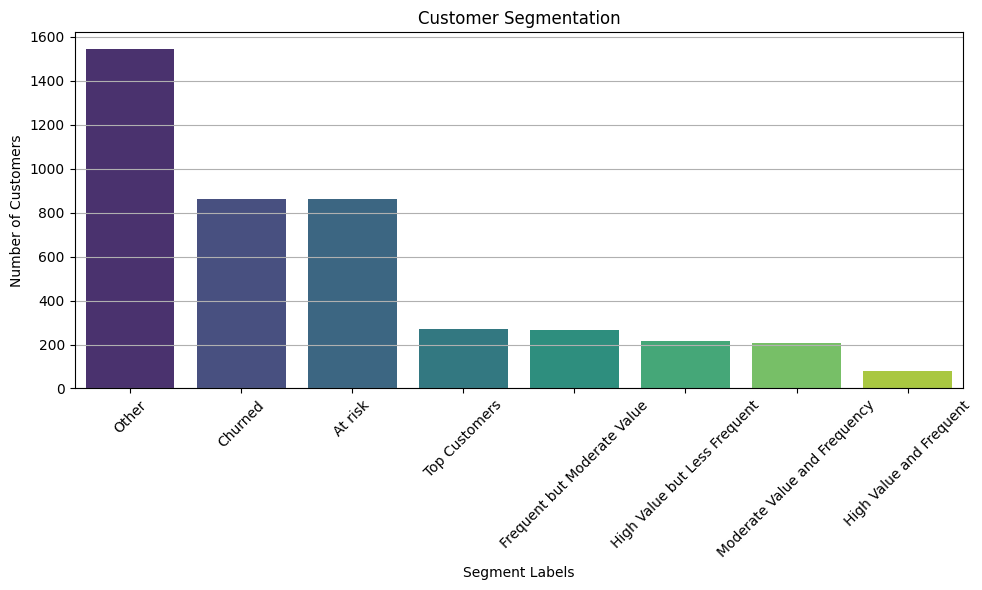

In [93]:
segment_counts = rfm['SegmentLabel'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

# Customize the plot
plt.title('Customer Segmentation')
plt.xlabel('Segment Labels')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Need to work on customer satisfaction with promotion to our at risk customer based on their buying history. A win-win back scenario. For example:

Create offers based on their previous buying habits.
Discounts on their favorite products
Bundled offers related to items they previously purchased
Loyalty points or rewards for returning
Exclusive Deals: Consider offering a limited-time promotion (e.g., “We miss you! Enjoy 20% off your next purchase”).

#Scaling

In [ ]:
from scipy import stats

def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

<ipython-input-82-684108d2bf09>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Recency's: Skew: 1.230169816708642, : SkewtestResult(statistic=26.298526935074396, pvalue=1.9935753217661197e-152)


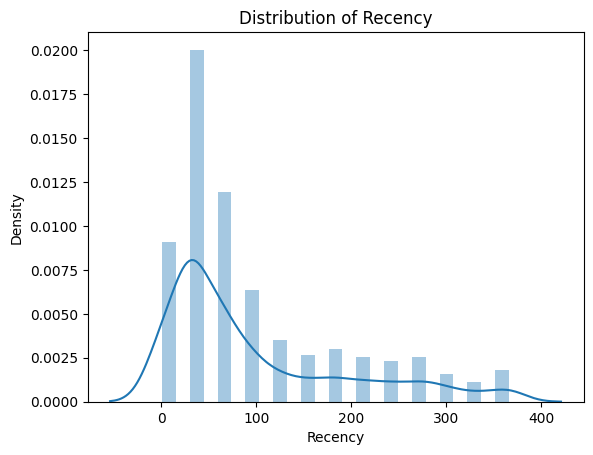

In [ ]:
check_skew(rfm, 'Recency')

<ipython-input-82-684108d2bf09>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Frequency's: Skew: 12.89495671458085, : SkewtestResult(statistic=75.86831840997206, pvalue=0.0)


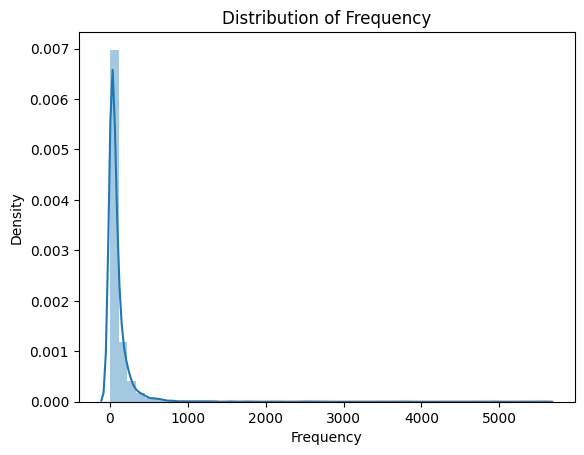

In [ ]:
check_skew(rfm, 'Frequency')

<ipython-input-82-684108d2bf09>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Monetary's: Skew: 23.991765046924797, : SkewtestResult(statistic=89.50170930295543, pvalue=0.0)


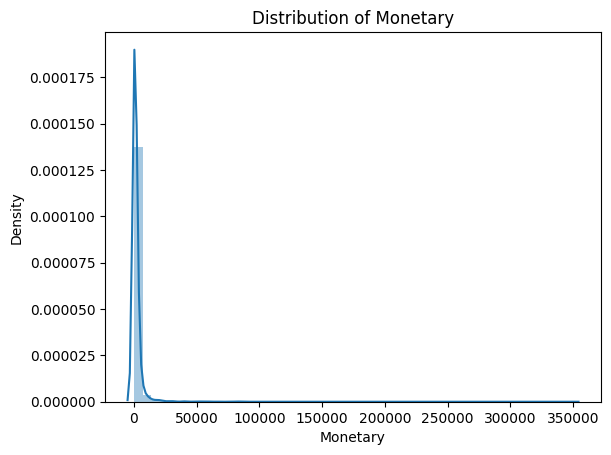

In [ ]:
check_skew(rfm, 'Monetary')

Data is skewed. So, normalizing the data using logarithm.

In [ ]:
rfm['log_Frequency'] = np.log(rfm['Frequency'])
rfm['log_Recency'] = np.log(rfm['Recency'])
rfm['log_Monetary'] = np.log(rfm['Monetary'])
rfm.head()

Customer ID  Recency  Frequency  Monetary RecencyScore FrequencyScore  \
0      12346.0      184         24    169.36            2              2   
1      12347.0        1         71   1323.32            5              4   
2      12348.0       92         20    222.16            3              2   
3      12349.0       62        102   2671.14            3              4   
4      12351.0       31         21    300.93            5              2   

  MonetaryScore Segment  log_Frequency  log_Recency  log_Monetary  
0             1     221       3.178054     5.214936      5.132027  
1             4     544       4.262680     0.000000      7.187899  
2             1     321       2.995732     4.521789      5.403398  
3             5     345       4.624973     4.127134      7.890261  
4             2     522       3.044522     3.433987      5.706878

<ipython-input-118-684108d2bf09>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



log_Recency's: Skew: -1.246328050907046, : SkewtestResult(statistic=-26.537830625821393, pvalue=3.5490667499358754e-155)


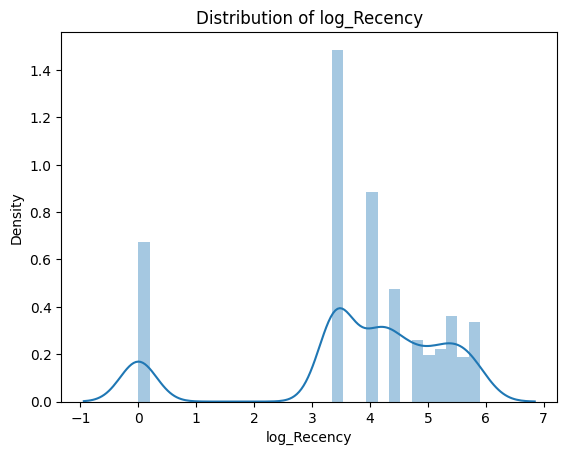

In [ ]:
check_skew(rfm, 'log_Recency')

<ipython-input-82-684108d2bf09>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



log_Frequency's: Skew: -0.3194010139852862, : SkewtestResult(statistic=-8.373381565029828, pvalue=5.598795132051445e-17)


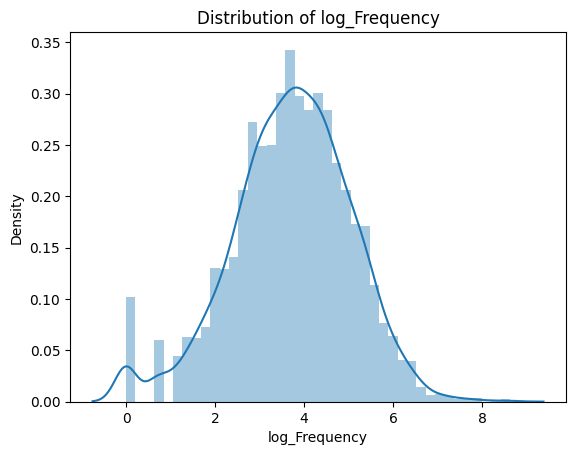

In [ ]:
check_skew(rfm, 'log_Frequency')

<ipython-input-82-684108d2bf09>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



log_Monetary's: Skew: 0.22861386965949176, : SkewtestResult(statistic=6.0621641219830735, pvalue=1.3430206409106336e-09)


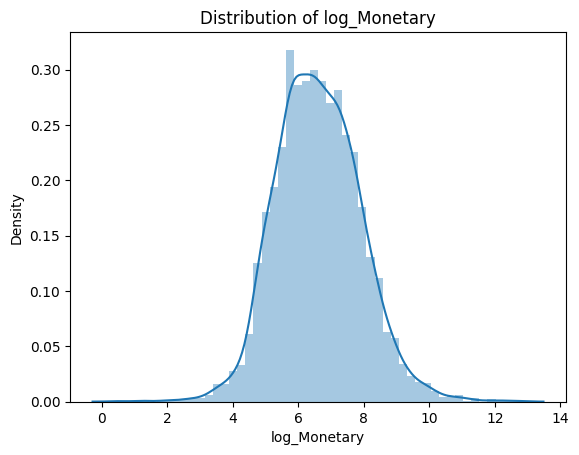

In [ ]:
check_skew(rfm, 'log_Monetary')

Shape of histogram looks pretty decent. So, I am using it.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['log_Recency', 'log_Frequency', 'log_Monetary']])
rfm_scaled

array([[ 0.85101814, -0.39804166, -1.14418265],
       [-2.26303387,  0.41331863,  0.45266526],
       [ 0.43711153, -0.53442828, -0.93340179],
       ...,
       [ 1.15083783, -0.91655411, -0.42590027],
       [ 0.61051876,  0.36994096,  0.43671956],
       [-0.21245928,  0.54794718,  0.89729726]])

#KMeans

In [ ]:
!pip install kneed

In [ ]:
wcss = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, init= 'k-means++')
  kmeans.fit(rfm_scaled)
  wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

In [ ]:
wcss

[12936.000000000033,
 7181.371968601886,
 4876.645566752068,
 3871.3477415410903,
 3319.1993594726277,
 2822.234399950498,
 2535.6354079214907,
 2332.231600339492,
 2138.3346535851256,
 1975.9259277166068]

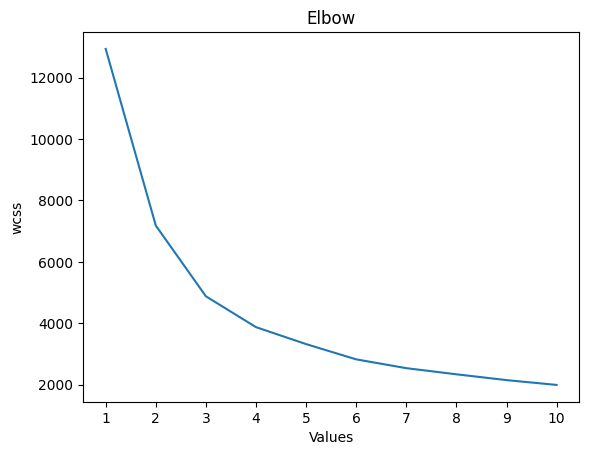

In [ ]:
plt.plot(range(1, 11), wcss)
plt.xticks(range(1, 11))
plt.xlabel('Values')
plt.ylabel('wcss')
plt.title('Elbow')
plt.show()

elbow is either 2 or 3. Now I will use the automatic method using KneeLocator. Double checking the n_clusters

In [ ]:
from kneed import KneeLocator

In [ ]:
KL = KneeLocator(range(1,11), wcss, curve = 'convex', direction = 'decreasing') #wcss decrease sp curve is convex
KL.elbow

3

In [ ]:
kmeans = KMeans(n_clusters = 3, init= 'k-means++')

In [ ]:
rfm['Clusters'] = kmeans.fit_predict(rfm_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [ ]:
silhouette_coefficient = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, init= 'k-means++')
  kmeans.fit(rfm_scaled)
  score = silhouette_score(rfm_scaled, kmeans.labels_)
  silhouette_coefficient.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

In [ ]:
silhouette_coefficient

[0.38696050898673096,
 0.4106349812660659,
 0.34372492154629886,
 0.3452464937194265,
 0.31042368709016915,
 0.3074741302646584,
 0.3063253795152267,
 0.29512444434976914,
 0.2842358875227296]

In [ ]:
score = silhouette_score(rfm_scaled, kmeans.labels_)
score

0.28217824196971986

n_clusters = 3 gives the best score as silhouette coefficient is max at that point.

A silhouette score of 0.28 indicates that the clustering structure is not very strong. The clusters are somewhat overlapping, which means that:

*   Clusters might be too close to each other.

*   Clusters might not be well-separated, leading to mixed membership for some data points.



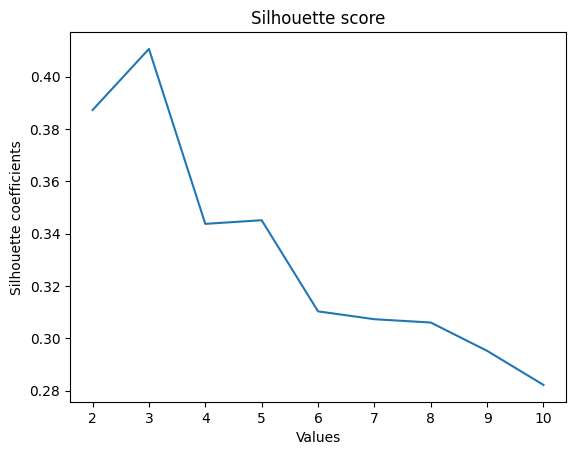

In [ ]:
plt.plot(range(2, 11), silhouette_coefficient)
plt.xlabel('Values')
plt.ylabel('Silhouette coefficients')
plt.title('Silhouette score')
plt.xticks(range(2, 11))
plt.show()

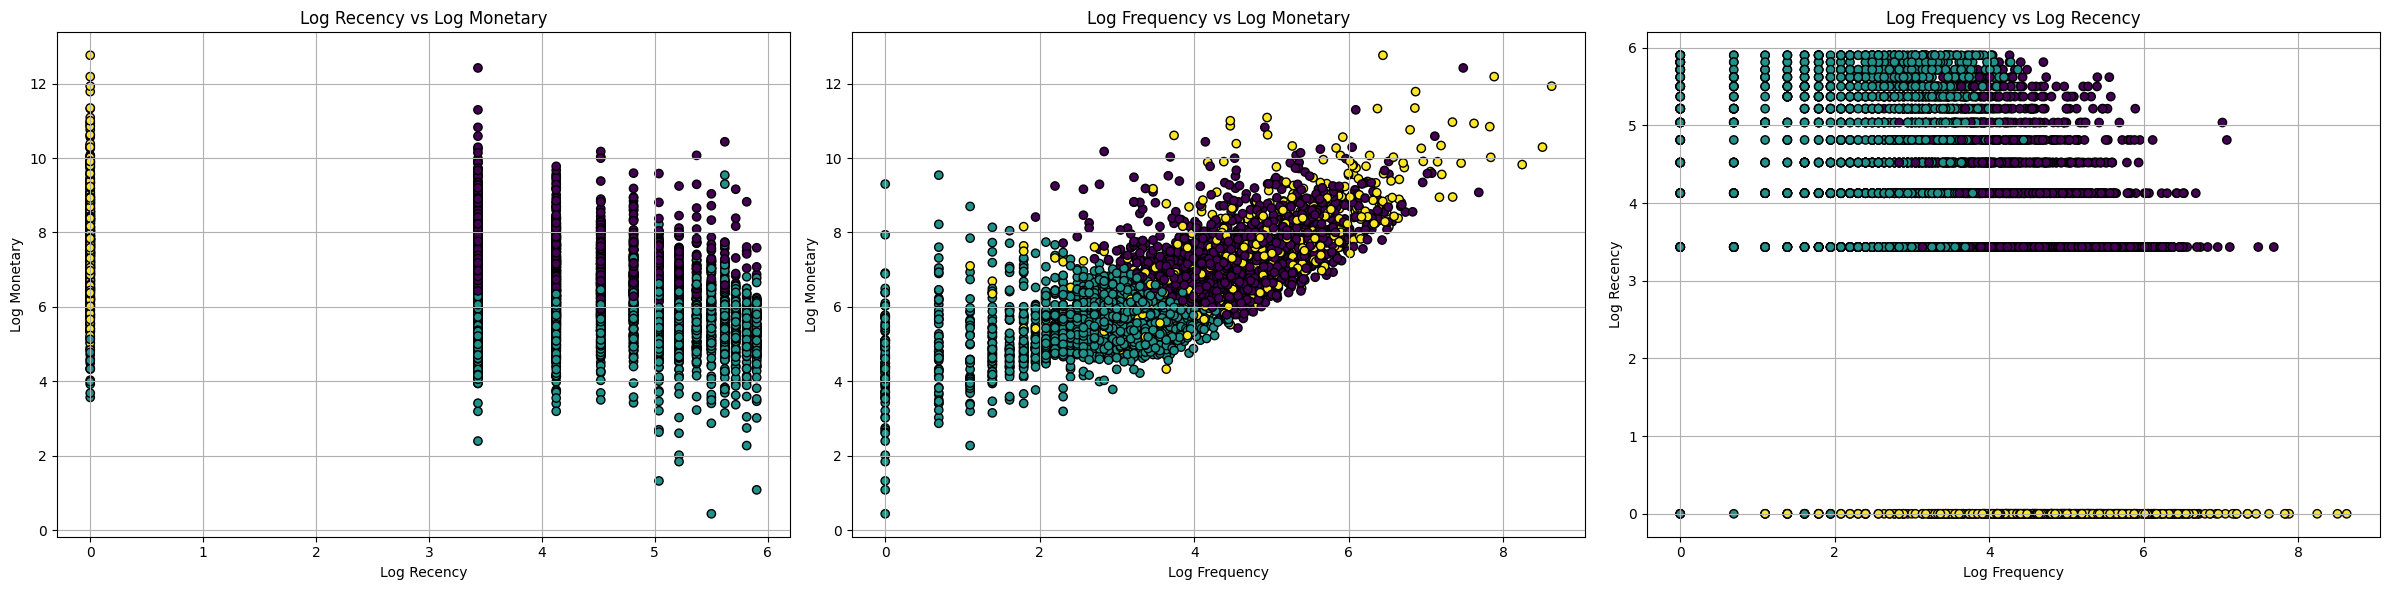

In [ ]:
ig, axs = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Define plot titles and labels
titles = ['Log Recency vs Log Monetary', 'Log Frequency vs Log Monetary', 'Log Frequency vs Log Recency']
x_labels = ['Log Recency', 'Log Frequency', 'Log Frequency']
y_labels = ['Log Monetary', 'Log Monetary', 'Log Recency']

# Data for cluster centers


# Define cluster labels for legend
cluster_labels = [f'Cluster {i+1}' for i in range(kmeans.n_clusters)]

# Plot 1: Log Recency vs Log Monetary
scatter1 = axs[0].scatter(rfm['log_Recency'], rfm['log_Monetary'], c=rfm['Clusters'], cmap='viridis', edgecolor='k')
axs[0].set_xlabel(x_labels[0])
axs[0].set_ylabel(y_labels[0])
axs[0].set_title(titles[0])
axs[0].grid(True)

# Plot 2: Log Frequency vs Log Monetary
scatter2 = axs[1].scatter(rfm['log_Frequency'], rfm['log_Monetary'], c=rfm['Clusters'], cmap='viridis', edgecolor='k')
axs[1].set_xlabel(x_labels[1])
axs[1].set_ylabel(y_labels[1])
axs[1].set_title(titles[1])
axs[1].grid(True)

# Plot 3: Log Frequency vs Log Recency
scatter3 = axs[2].scatter(rfm['log_Frequency'], rfm['log_Recency'], c=rfm['Clusters'], cmap='viridis', edgecolor='k')
axs[2].set_xlabel(x_labels[2])
axs[2].set_ylabel(y_labels[2])
axs[2].set_title(titles[2])
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

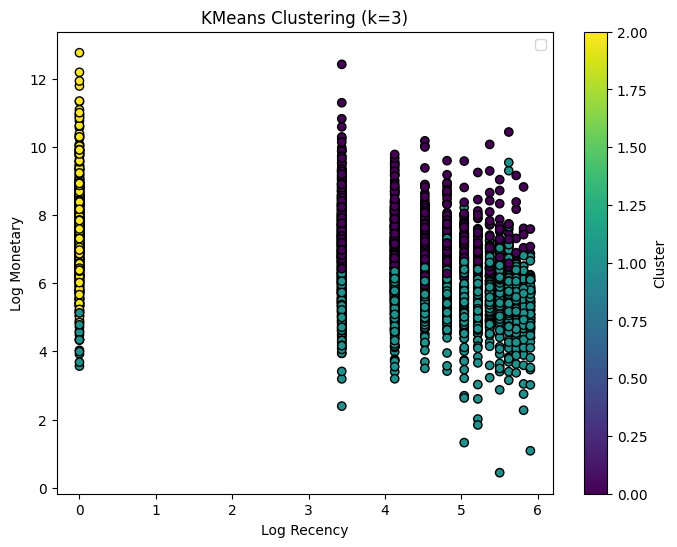

In [ ]:
#plt.figure(figsize=(8, 6))
#scatter = plt.scatter(rfm['log_Recency'], rfm['log_Monetary'], c=rfm['Clusters'], cmap='viridis', edgecolor='k')
#plt.colorbar(scatter, label='Cluster')
##plt.xlabel('Log Recency')
#plt.ylabel('Log Monetary')
#plt.title('KMeans Clustering (k=3)')

# Plot cluster centers
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

# Add legend
#plt.legend()

# Show plot
#plt.show()

In [ ]:
#plt.figure(figsize=(8, 6))
#scatter = plt.scatter(rfm['log_Recency'], rfm['log_Frequency'], c=rfm['Clusters'], cmap='viridis', edgecolor='k')
#plt.colorbar(scatter, label='Cluster')
#plt.xlabel('Log Recency')
#plt.ylabel('Log Frequency')
#plt.title('KMeans Clustering (k=3)')

# Plot cluster centers
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

# Add legend
#plt.legend()

# Show plot
#plt.show()

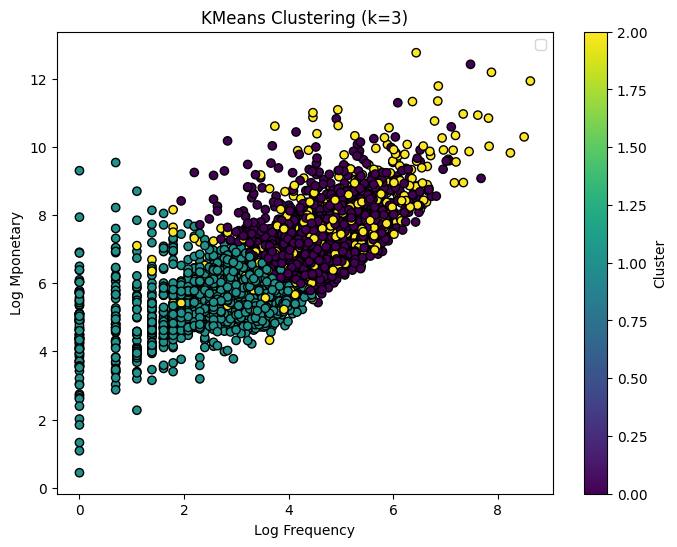

In [ ]:
#plt.figure(figsize=(8, 6))
#scatter = plt.scatter(rfm['log_Frequency'], rfm['log_Monetary'], c=rfm['Clusters'], cmap='viridis', edgecolor='k')
##plt.colorbar(scatter, label='Cluster')
#plt.xlabel('Log Frequency')
#plt.ylabel('Log Mponetary')
#plt.title('KMeans Clustering (k=3)')

# Plot cluster centers
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

# Add legend
#plt.legend()

# Show plot
#plt.show()

Silhouette coefficient is maximum at 3 which is around 0.42. Hence, 3 is right number of clusters

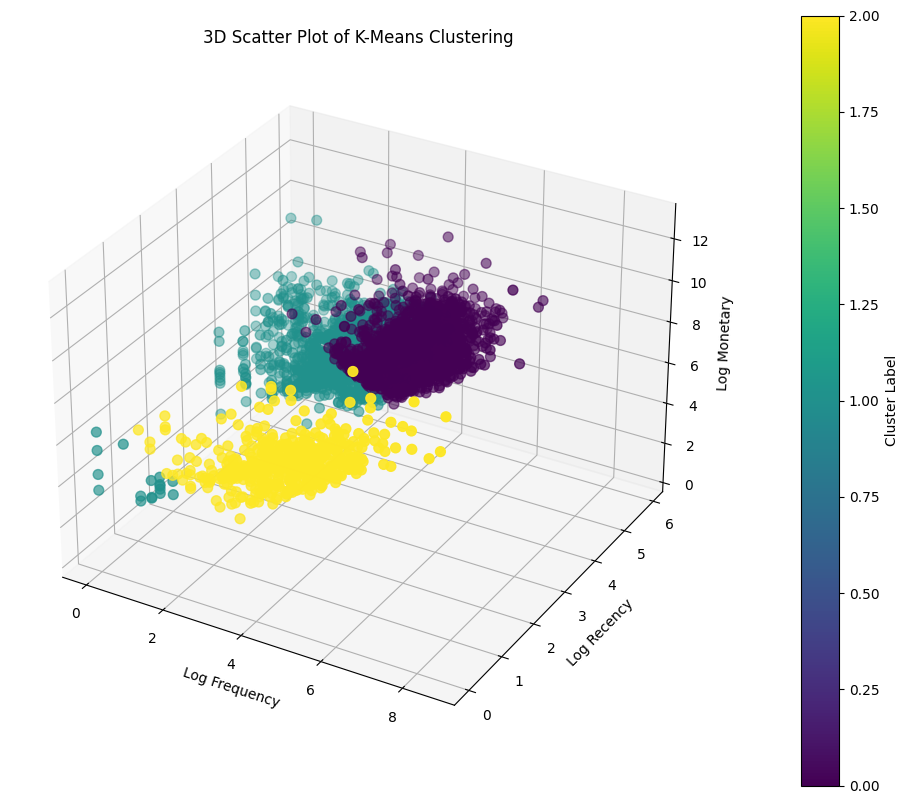

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
scatter = ax.scatter(rfm['log_Frequency'], rfm['log_Recency'], rfm['log_Monetary'], c=rfm['Clusters'], cmap='viridis', s=50)

# Plot cluster centroids
#centroids = kmeans.cluster_centers_
#ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=300, c='red', marker='X', label='Centroids')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Label')

# Labels and title
ax.set_xlabel('Log Frequency')
ax.set_ylabel('Log Recency')
ax.set_zlabel('Log Monetary')
ax.set_title('3D Scatter Plot of K-Means Clustering')

# Add legend if centroids are plotted
# ax.legend()

plt.show()

In [ ]:
rfm.head()

Customer ID  Recency  Frequency  Monetary RecencyScore FrequencyScore  \
0      12346.0      184         24    169.36            2              2   
1      12347.0        1         71   1323.32            5              4   
2      12348.0       92         20    222.16            3              2   
3      12349.0       62        102   2671.14            3              4   
4      12351.0       31         21    300.93            5              2   

  MonetaryScore Segment  log_Frequency  log_Recency  log_Monetary  Clusters  \
0             1     221       3.178054     5.214936      5.132027         1   
1             4     544       4.262680     0.000000      7.187899         2   
2             1     321       2.995732     4.521789      5.403398         1   
3             5     345       4.624973     4.127134      7.890261         0   
4             2     522       3.044522     3.433987      5.706878         1   

          Cluster_DBSCAN  
0  DBSCAN(min_samples=6)  
1  DBSCAN(min_samples=6)  
2  DBSCAN(min_samples=6)  
3  DBSCAN(min_samples=6)  
4  DBSCAN(min_samples=6)

In [ ]:
cluster_counts = rfm['Clusters'].value_counts().reset_index()
cluster_counts.columns = ['Clusters', 'Count']

print(cluster_counts)

   Clusters  Count
0         1   1929
1         0   1827
2         2    556


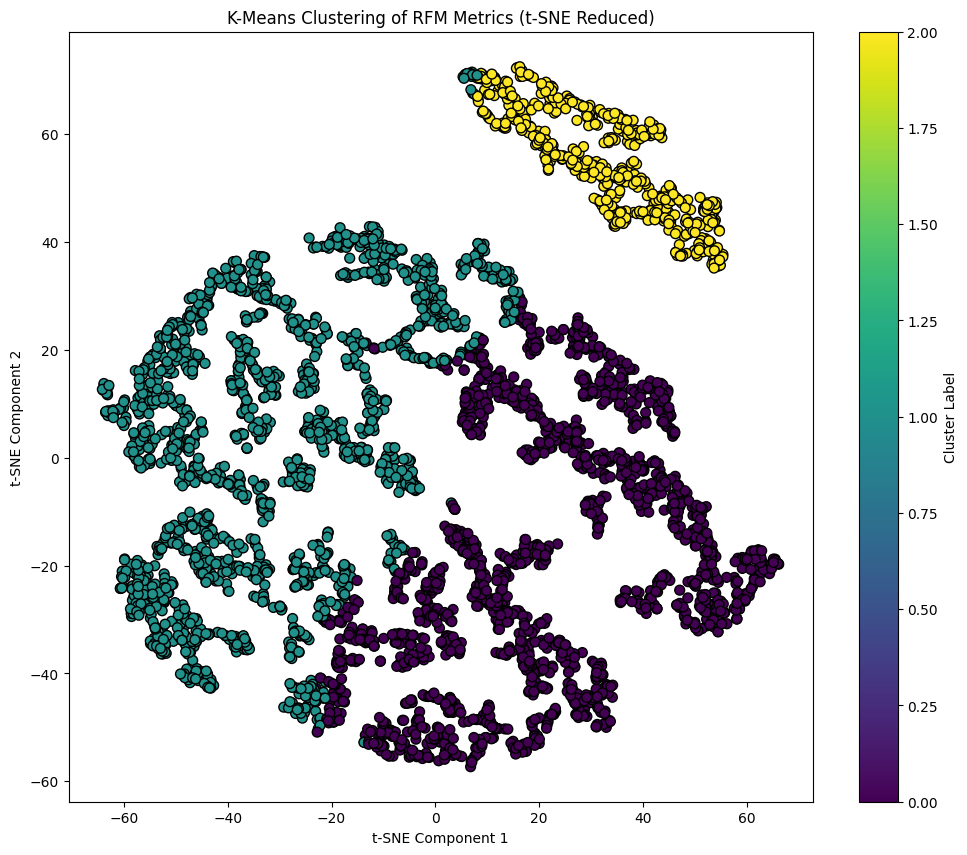

In [ ]:

tsne = TSNE(n_components=2, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Plot the clusters using t-SNE components
plt.figure(figsize=(12, 10))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=rfm['Clusters'], cmap='viridis', edgecolor='k', s=50)
plt.title('K-Means Clustering of RFM Metrics (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')  # Add color bar for cluster labels
plt.show()

#DBSCAN

In [ ]:
eps_values = np.arange(0.5, 10.5, 0.5)
min_samples_values = [3, 10]

best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(rfm_scaled)
        labels = db.labels_

        # Check if the number of clusters is more than 1 (excluding noise)
        if len(set(labels)) > 1 and -1 in labels:
            mask = labels != -1
            X_filtered = rfm_scaled[mask]
            labels_filtered = labels[mask]

            score = silhouette_score(X_filtered, labels_filtered)
            print(f"eps={eps}, min_samples={min_samples}, Silhouette Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best Silhouette Score: {best_score:.4f} with eps={best_eps} and min_samples={best_min_samples}")

eps=0.5, min_samples=3, Silhouette Score: 0.2736
eps=0.5, min_samples=10, Silhouette Score: 0.3726
eps=1.0, min_samples=3, Silhouette Score: 0.4733
eps=1.0, min_samples=10, Silhouette Score: 0.4728
Best Silhouette Score: 0.4733 with eps=1.0 and min_samples=3


In [ ]:
dbscan = DBSCAN(eps = 1, min_samples = 3)

In [ ]:
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_scaled)
rfm.head()

Customer ID  Recency  Frequency  Monetary RecencyScore FrequencyScore  \
0      12346.0      184         24    169.36            2              2   
1      12347.0        1         71   1323.32            5              4   
2      12348.0       92         20    222.16            3              2   
3      12349.0       62        102   2671.14            3              4   
4      12351.0       31         21    300.93            5              2   

  MonetaryScore Segment  log_Frequency  log_Recency  log_Monetary  \
0             1     221       3.178054     5.214936      5.132027   
1             4     544       4.262680     0.000000      7.187899   
2             1     321       2.995732     4.521789      5.403398   
3             5     345       4.624973     4.127134      7.890261   
4             2     522       3.044522     3.433987      5.706878   

   Cluster_DBSCAN  
0               0  
1               1  
2               0  
3               0  
4               0

In [ ]:
rfm['Cluster_DBSCAN'].value_counts()

Cluster_DBSCAN
 0    3736
 1     573
-1       3
Name: count, dtype: int64

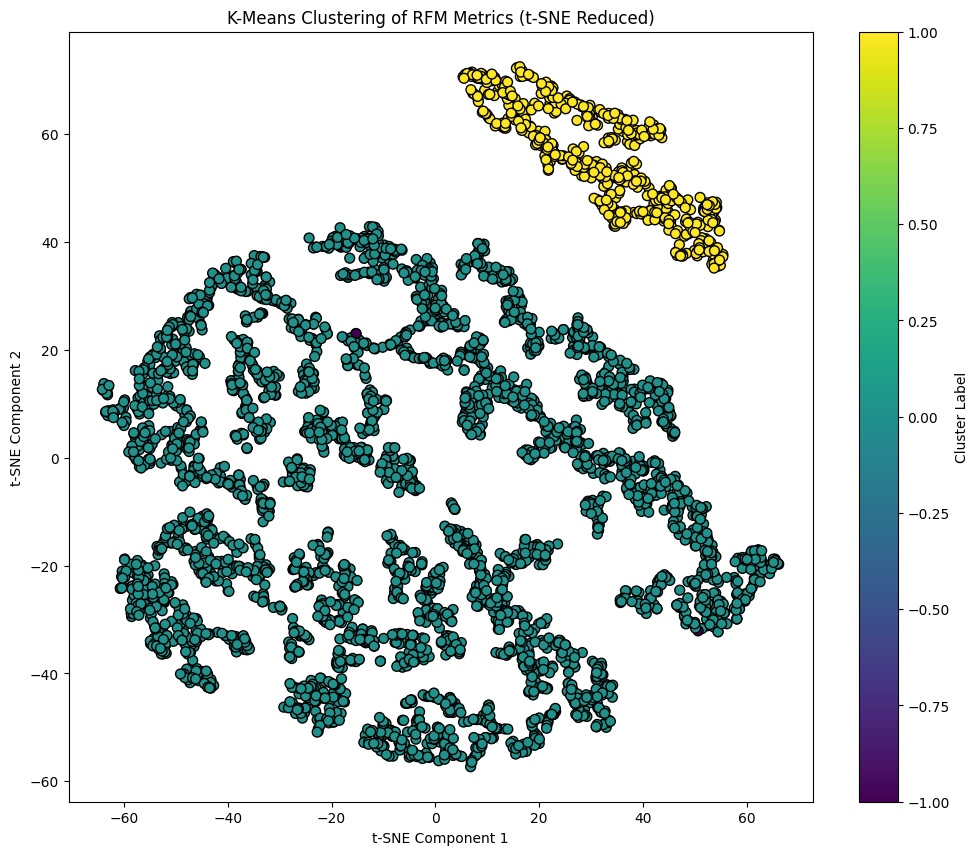

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
rfm_tsne_db = tsne.fit_transform(rfm_scaled)

# Plot the clusters using t-SNE components
plt.figure(figsize=(12, 10))
plt.scatter(rfm_tsne_db[:, 0], rfm_tsne_db[:, 1], c=rfm['Cluster_DBSCAN'], cmap='viridis', edgecolor='k', s=50)
plt.title('K-Means Clustering of RFM Metrics (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')  # Add color bar for cluster labels
plt.show()

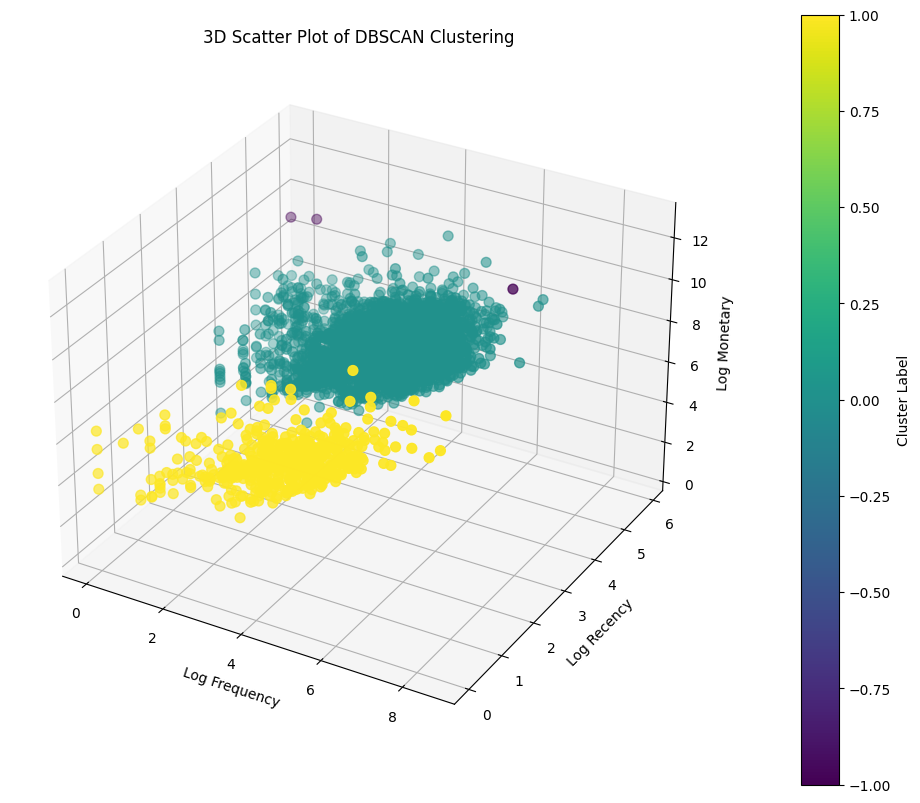

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
scatter = ax.scatter(rfm['log_Frequency'], rfm['log_Recency'], rfm['log_Monetary'], c=rfm['Cluster_DBSCAN'], cmap='viridis', s=50)

# Plot cluster centroids
#centroids = kmeans.cluster_centers_
#ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=300, c='red', marker='X', label='Centroids')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Label')

# Labels and title
ax.set_xlabel('Log Frequency')
ax.set_ylabel('Log Recency')
ax.set_zlabel('Log Monetary')
ax.set_title('3D Scatter Plot of DBSCAN Clustering')

# Add legend if centroids are plotted
# ax.legend()

plt.show()

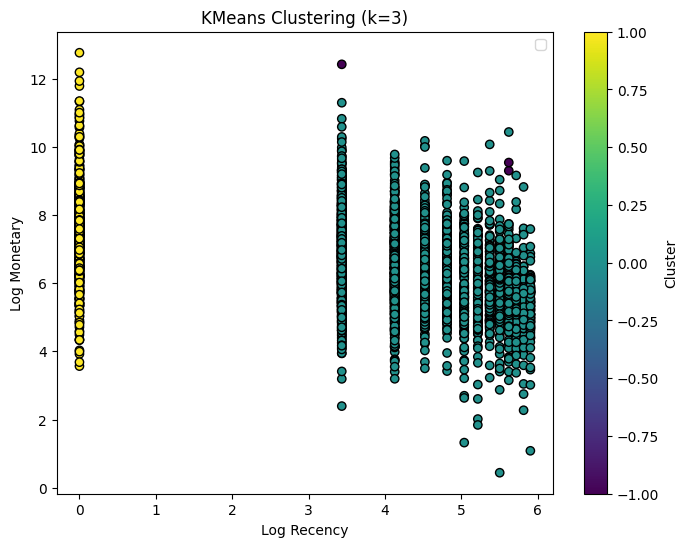

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rfm['log_Recency'], rfm['log_Monetary'], c=rfm['Cluster_DBSCAN'], cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Log Recency')
plt.ylabel('Log Monetary')
plt.title('KMeans Clustering (k=3)')

plt.legend()

# Show plot
plt.show()

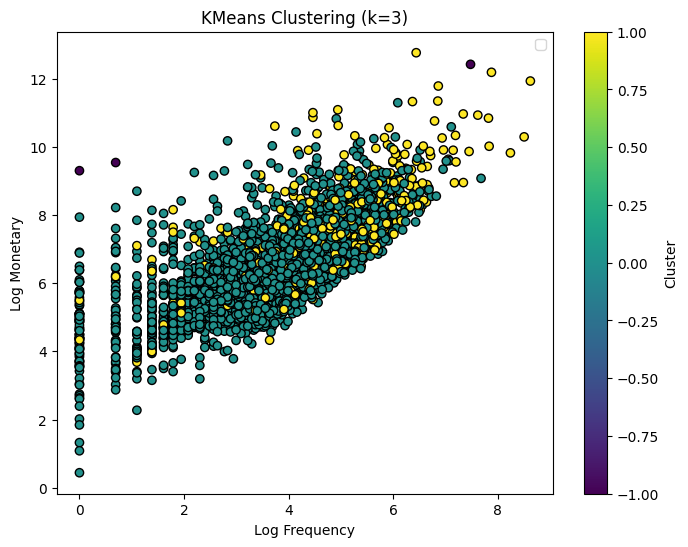

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rfm['log_Frequency'], rfm['log_Monetary'], c=rfm['Cluster_DBSCAN'], cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Log Frequency')
plt.ylabel('Log Monetary')
plt.title('KMeans Clustering (k=3)')

plt.legend()

# Show plot
plt.show()

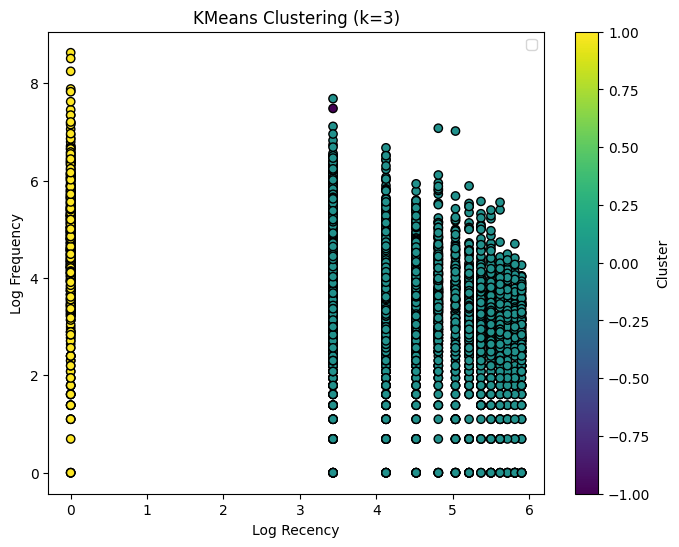

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rfm['log_Recency'], rfm['log_Frequency'], c=rfm['Cluster_DBSCAN'], cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Log Recency')
plt.ylabel('Log Frequency')
plt.title('KMeans Clustering (k=3)')

plt.legend()

# Show plot
plt.show()